In [1]:
from tqdm import tqdm
import numpy as np

def rand_ds(k = 3):
    m = np.zeros((k,k))
    i = 0
    while True:
        i+=1
        # generate random transition probabilities
        m[:k-1,:k-1] = np.random.uniform(size=(k-1,k-1))
        m[k-1,:k-1] = 1 - m[:k-1,:k-1].sum(axis=0)
        if m[k-1,:k-1].min() < 0:
            continue
        m[:k,k-1] = 1 - m[:,:k-1].sum(axis=1)
        if m[:k,k-1].min() > 0:
            print(i)
            return m
# rand = rand_ds
# print(rand(5))
# mats = [rand(4) for _ in tqdm(range(10000))]
# mats_squared = [np.linalg.matrix_power(m, 2) for m in mats]



array([[ 0.15040883,  0.12297993, -0.156766  , -0.11662272],
       [-0.19593912,  0.06511289,  0.25126582, -0.12043957],
       [-0.0036213 , -0.08859305,  0.04110572,  0.05110863],
       [ 0.04915163, -0.09949976, -0.13560556,  0.18595366]],
      dtype=float32)

In [14]:
import torch
import numpy as np
def slightly_faster(k=3, n = 100, m = None):
    if m is None:
        m = torch.zeros((n, k,k), device="cuda")
    m[:,:k-1,:k-1] = torch.rand(size=(n, k-1,k-1), device="cuda")
    # m[:,:k-1,:k-1] = torch.distributions.dirichlet.Dirichlet(torch.ones((k,k))).sample((n,))[:,:k-1,:k-1]

    # m = m.view(n*k, k)
    # m = m[(m.sum(axis=1)<1)]
    # m = m[:len(m)-(len(m)%k)]
    # m = m.view(len(m)//k,k,k)
    # m = m[(m.sum(axis=1)<1).all(axis=1)]
    # m = m[:len(m)-(len(m)%k)]
    # print(m.shape)
    m = m[(m.sum(axis=1)<1).all(dim=1)]
    m = m[(m.sum(axis=2)<1).all(dim=1)]
    # print(len(m))
    # print("generated")
    m[:,k-1,:k-1] = 1 - m[:, :k-1,:k-1].sum(axis=1)
    # print('step one')
    m[:,:k,k-1] = 1 - m[:,:,:k-1].sum(axis=2)
    # print((m[:,-1,-1]>0).sum())
    # m = m[(m[:,k-1,:k-1]> 0).all(dim=1)]
    # m = m[(m[:,:k,k-1]>0).all(dim=1)]
    # print(len(m))
    # print('step two')
    # print(((m[:,:k,k-1].min(axis=1)[0] >= 0 ) *(m[:,k-1,:k-1].min(axis=1)[0] >= 0)).sum())
    return m[m[:,-1,-1]>0]
    # m = m[(m[:,k-1,:k-1].min(axis=1)[0] >= 0)]
    # return m[(m[:,:k,k-1].min(axis=1)[0] >= 0 )]

# print(sum([len(slightly_faster(5, int(1e8))) for i in range(10)]))
mats = []
n = int(1e7)
k = 4
tot = 0
if "m" in locals():
    del m
m = torch.zeros((n, k,k), device="cuda")
while len(mats)< 1000:
    tot += 1
    mats.extend(slightly_faster(k,n, m))
    if tot %1000 == 0:
        print(tot)
print(tot)
mats = torch.stack(mats)
# mats = [i for i in mats]

1


In [29]:
# print(np.mean([(m * m).sum() for m in mats2]))
# print(np.mean(np.multiply(mats,mats))*mats[0].shape[1]**2)
# print(((np.multiply(mats,mats))).sum(axis=(1,2)).min())
# print((mats[482]**2).sum())
power = torch.linalg.matrix_power(mats,2)
print(mats.shape)
print(((power**2).sum(dim=2)-(power * mats).sum(dim=2)).max())
print(((mats**2).sum(dim=(1,2))).mean())

SyntaxError: unmatched ')' (3563396259.py, line 7)

In [54]:
def doubly_stochastic_non_uniform(k=3):
    # Generate a random k x k stochastic matrix
    A = np.random.dirichlet(np.ones(k), size=k)
    
    # Iteratively adjust rows and columns
    for _ in range(100):  # Iteration limit to prevent infinite loops
        # Normalize columns
        A = A / A.sum(axis=0, keepdims=True)
        # Normalize rows
        A = A / A.sum(axis=1, keepdims=True)
    
    return A

mats = [doubly_stochastic_non_uniform(5) for _ in tqdm(range(100000))]

100%|██████████| 100000/100000 [00:55<00:00, 1795.31it/s]


In [38]:
print(np.mean([(m * m).sum() for m in np.random.dirichlet([1,1,1], size=(1000,3))]))
print(np.mean([(m * np.linalg.matrix_power(m,2)).sum() for m in np.random.dirichlet([1,1,1], size=(1000,3))]))

1.5024145398711224
1.1648581800112394


0.97838026


In [106]:
for i in range(len(mats)):
    if (mats[i] * mats[i]).sum() < (mats[i]*mats_squared[i]).sum():
        print(mats[i])

In [79]:
a = mats[0]
b = mats[1]
temp = 0
for i in range(3):
    print((mats[i] * mats[i]).sum()/(mats[i]*mats_squared[i]).sum())

1.2284969191907364
1.4355274245597154
1.2087944857743025


In [118]:
# %autoreload
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
import pickle
import numpy as np
import utils

from utils import stationary_distribution, compare_test
from mingpt.utils import set_seed
import importlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from textwrap import wrap
import os
import seaborn as sns
sns.set_theme()

In [42]:
# set_seed(242)
import datasets
importlib.reload(datasets)
from copy import deepcopy
length = 101
num_tokens = 2
n = 2
train_dataset = datasets.ngrams('train', n, length, num_tokens)
test_dataset = datasets.ngrams('test', n, length, num_tokens)
# train_dataset = datasets.monogram("train", length, num_tokens)
# test_dataset = datasets.monogram("test", length, num_tokens)
# train_dataset = datasets.spectrum('train', 0, length, num_tokens)
# test_dataset = datasets.spectrum('test', 0, length, num_tokens)
x, y = test_dataset[0]
print(len(test_dataset))
print(len(x))
print(y)



1024
100
(tensor([[0.2019, 0.7981],
        [0.3471, 0.6529]], dtype=torch.float64), tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1]))


In [8]:
from mingpt.model_modified_variable_attention import Attention_Only_GPT
# from mingpt.model_transformer_only import Attention_Only_GPT
# from mingpt.model import GPT
from mingpt.trainer import Trainer
import mingpt
# importlib.reload(mingpt.model_modified_variable_attention)

model_config = Attention_Only_GPT.get_default_config()
# model_config = GPT.get_default_config()
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
# model_config.model_type = "gpt-nano"
model_config.abs_embd = False
model_config.causal = True
model_config.n_layer = 2
# model_config.minimal = False
# model = GPT(model_config)
model = Attention_Only_GPT(model_config)
# model.transformer.h[0].attn.Q = torch.nn.Identity(model_config.n_embd, model_config.n_embd)
# model.transformer.h[0].attn.Q.requires_grad_(False)
# model.transformer.h[0].attn.Q.weight = torch.nn.Parameter(torch.zeros_like(model.transformer.h[0].attn.Q.weight))

# # for param in model.transformer.wpe.parameters():
# #     param.requires_grad = False

# # for param in model.transformer.h[0].parameters():
# #     param.requires_grad = False

number of parameters: 8576


In [9]:
# from mingpt.minimal_ngram import min_model
# # from mingpt.trainer import Trainer
# # import mingpt
# # set_seed(10)
# # model = min_model(train_dataset.get_block_size(), train_dataset.get_vocab_size(), key=True, query=False, value=False)
# model = min_model(train_dataset.get_block_size(), train_dataset.get_vocab_size())

In [10]:
train_config = Trainer.get_default_config()
train_config.max_iters = 2000#12000#*10*2
train_config.num_workers = 6
train_config.batch_size = 64
# train_config.weight_decay = 0
# train_config.learning_rate = 1e-3
# train_config.learning_rate = 1e-5
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [11]:
import os
exprm_config = dict(length = length,
    num_tokens = num_tokens,
    # causal = model_config.causal,
    last_token_only = train_dataset.last_token_only,
    encoding_learned = True,
    # encoding = "none" if model_config.abs_embd else "rel",
    embd_dim = model_config.n_embd,
    layers = model_config.n_layer,
    heads = model_config.n_head
    )
# exprm_config['length'] = 101
# exprm_config['num_tokens'] = 5
# exprm_config['causal'] = True
# exprm_config['last_token_only'] = False
# exprm_config['encoding_learned'] = True
# exprm_config['encoding'] = "abs" # or "rel"

path = './results'
for k, v in exprm_config.items():
    path = os.path.join(path, f'{k}_{v}')

# os.makedirs(path, exist_ok=True)
# os.makedirs(os.path.join(path, 'checkpoints'), exist_ok=True)
# os.makedirs(os.path.join(path, 'plots'), exist_ok=True)

In [ ]:
model_history = []
train_loss = []
# print(model(torch.tensor([[0,1,2,3]*25], device = trainer.device)))

In [ ]:
# with torch.no_grad():
#     sns.heatmap(model.Wk.weight.cpu())
#     plt.show()

#     pos = torch.arange(length-1, dtype=torch.long, device=trainer.device)
#     # pos = pos.view(-1,1) - pos.view(1, -1) - 1
#     # pos[pos<0] = 0
#     # print(pos)
#     pos_embd = model.v(pos)[:, 0]
#     # print(pos_embd)
#     temp = pos_embd.cpu()
#     # print(temp.shape)
#     plt.scatter(range(len(temp)),temp)
#     plt.show()
#     # plt.scatter(range(5),model.Wk.bias.cpu())
#     # plt.show()

In [2]:
wait = train_config.max_iters// 5
num_models = 100 # number of models saved (assuming number of iterations is atleast as high)
# for param in model.transformer.h[0].parameters():
#     param.requires_grad = False
# for param in model.transformer.h[1].parameters():
#     param.requires_grad = False
# for param in model.transformer.wpe.parameters():
#     param.requires_grad = False

def batch_end_callback(trainer):
    with torch.no_grad():
      train_loss.append(trainer.loss.item())
      if trainer.iter_num % max(train_config.max_iters//num_models, 1) == 0:
        model_history.append(deepcopy(model))
        # torch.save(model.state_dict(), os.path.join(path, 'checkpoints', f'model_{trainer.iter_num}'))
    if trainer.iter_num % (train_config.max_iters// 5) == 0:
        print(f"iter_dt {trainer.iter_dt *1000:.2f} ms; iter {trainer.iter_num}: train loss {trainer.loss.item():f}")
trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()
print(len(model_history))

NameError: name 'train_config' is not defined

config seed: 0
number of parameters: 5472
running on device cuda:0
iter_dt 0.00 ms; iter 0: train loss 1.104762
iter_dt 6.05 ms; iter 800: train loss 0.993214
iter_dt 10.65 ms; iter 1600: train loss 0.922900
iter_dt 59.42 ms; iter 2400: train loss 0.921170
iter_dt 7.49 ms; iter 3200: train loss 0.907195


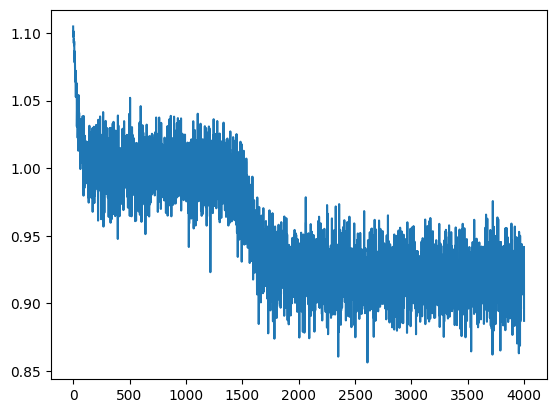

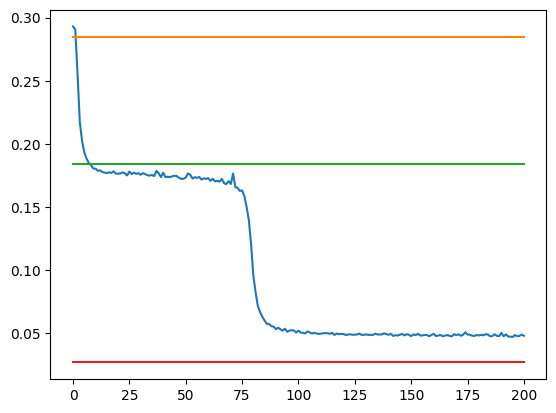

In [1]:
import training_pipeline
import test_error
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# sns.set_theme()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default = training_pipeline.get_default_config()
histories = []
datem = []
bigram_data = []
unigram_data = []
n = 2
default.vocab_size = 3
default.n_layer = 2
default.n_head = 1
# train_dataset = datasets.doubly_stochastic_3('train', 1, default.block_size+1, default.vocab_size)
# default.dataset = train_dataset
# default.batch_size =1000
default.max_iters = 4000
# default.learning_rate = 1.1e-3
# default.learning_rate = 1.1e-3
# default.learning_rate = 0
# default.model_type="Super Minimal Model"
test_dataset = datasets.ngrams('test', n, default.block_size+1, default.vocab_size)
if default.vocab_size == 3:
    bigram_dataset = datasets.doubly_stochastic_3('test', 1, default.block_size+1, num_symbols = default.vocab_size)
    unigram_dataset = datasets.unigram_3('test', 1, default.block_size+1, num_symbols=default.vocab_size)
if default.vocab_size == 2:
    bigram_dataset = datasets.interpolate('test', 1, default.block_size+1, 2)
    unigram_dataset = datasets.interpolate('test', 0, default.block_size+1, 2)
for seed in range(1):
    default.seed = seed
    model_history, train_loss = training_pipeline.train(default) 
    histories.append(model_history)
plt.plot(train_loss)
plt.show()
for model_history in histories:
    data = test_error.test_last_token(model_history, test_dataset, device)
    datem.append(data)
    plt.plot(datem[-1][0])
    data = test_error.test_last_token(model_history, bigram_dataset, device)
    bigram_data.append(data)
    data = test_error.test_last_token(model_history, unigram_dataset, device)
    unigram_data.append(data)
for i in datem[-1][1]:
    plt.plot((i,)*len(datem[-1][0]))
plt.show()


In [5]:
import graphing_pipeline
import importlib
from random import choices
importlib.reload(graphing_pipeline)
# test_dataset = datasets.ngrams('test', 2, default.block_size+1, default.vocab_size)
# idx = torch.stack([test_dataset[0][0][:16]]).to("cuda")
idx = torch.tensor([list(choices(range(default.vocab_size), k=16))]).cuda()
graphing_pipeline.flow(model_history[-1], idx)

NameError: name 'torch' is not defined

In [4]:
import graphing_pipeline
import importlib
importlib.reload(graphing_pipeline)
importlib.reload(test_error)
default.model_type = "Two Layer Attention Only Transformer"
fig, axes = graphing_pipeline.pos_encode_graph(model_history, datem, default)
name = f"{default.vocab_size}symb_train_bigram"
plt.savefig(f"final/{name}_pos.pdf", format='pdf')
plt.show()
fig, axes = graphing_pipeline.out_of_distribution(datem, unigram_data, bigram_data, default)
plt.show()
fig, axes = graphing_pipeline.similarity(datem, default)
plt.show()

NameError: name 'test_error' is not defined

config seed: 1
number of parameters: 5440
running on device cuda:0
iter_dt 0.00 ms; iter 0: train loss 0.680694
iter_dt 15.73 ms; iter 1600: train loss 0.524209


KeyboardInterrupt: 

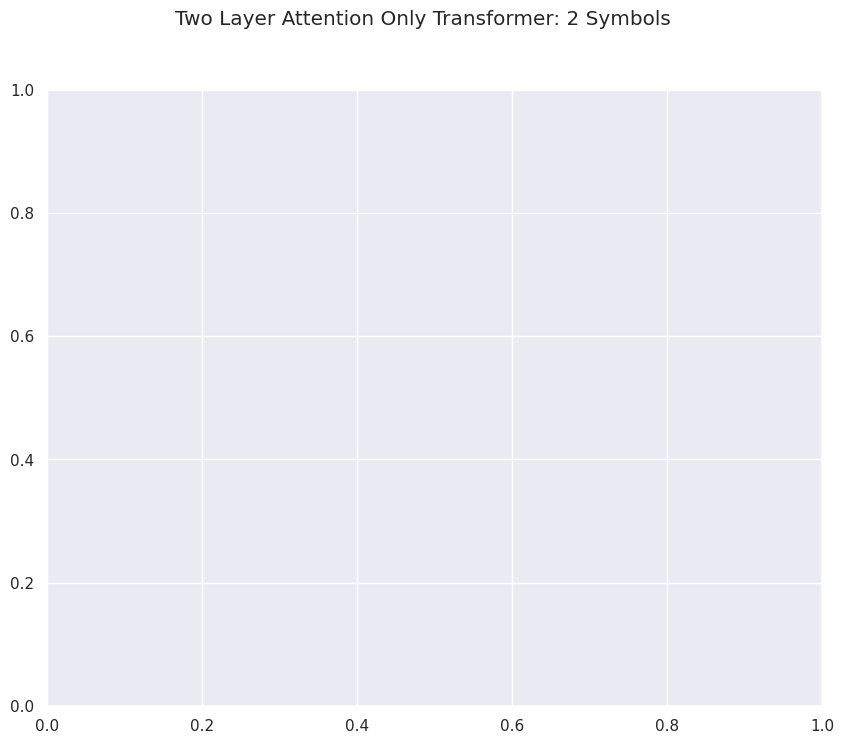

In [2]:
import graphing_pipeline
import training_pipeline
import test_error
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default = training_pipeline.get_default_config()
default.device = device
histories = []
datem = []
bigram_data = []
unigram_data = []
n = 2
default.vocab_size = 2
default.n_layer = 2
default.n_head = 1
# default.batch_size =1000
default.max_iters = 8000
default.learning_rate = 3e-5
fig, axis = graphing_pipeline.distribution_shift(default)
plt.show()

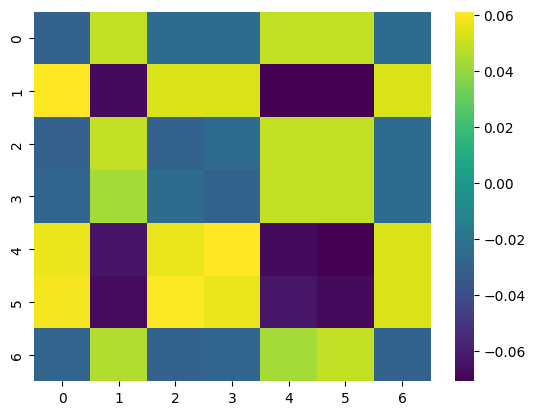

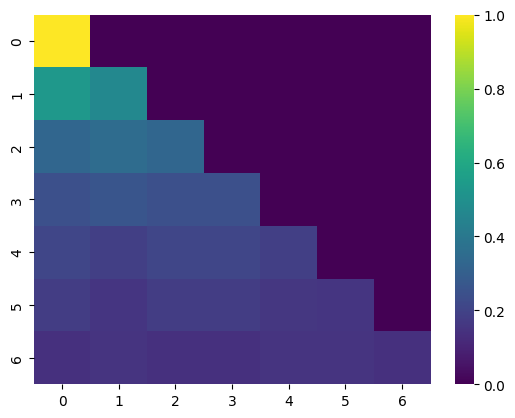

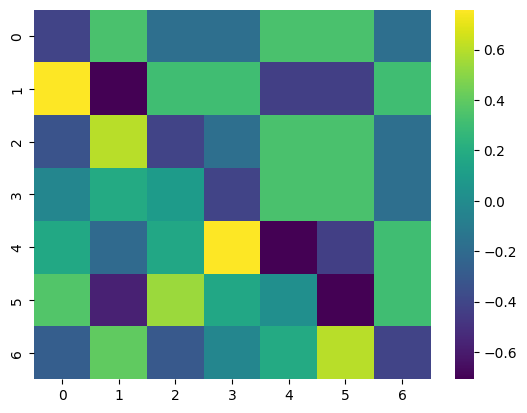

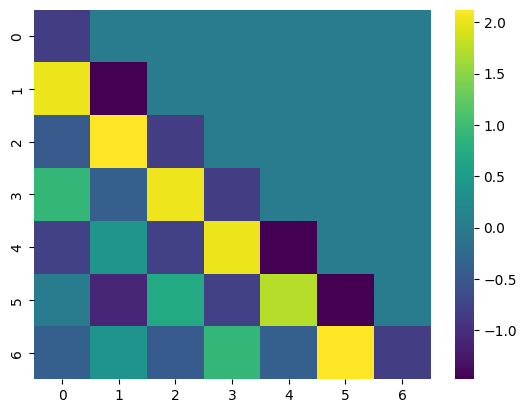

In [112]:
from mingpt.utils import set_seed
with torch.no_grad():
    m = model_history[5]
    set_seed(0)
    idx = torch.stack([test_dataset[0][0]]).to("cuda")
    idx = torch.tensor([[0,1,0,0,1,1,0]], device = device)
    attn, sm_attn = m.visualize_attention(idx)
    colors = sns.color_palette("viridis", as_cmap=True)
    sns.heatmap(attn[0].squeeze().cpu(), cmap=colors)
    plt.show()
    sns.heatmap(sm_attn[0].squeeze().cpu(), cmap=colors)
    plt.show()
    m = model_history[100]
    attn, sm_attn = m.visualize_attention(idx)
    sns.heatmap(attn[0].squeeze().cpu(), cmap=colors)
    plt.show()
    m = model_history[120]
    attn, sm_attn = m.visualize_attention(idx)
    sns.heatmap(attn[0].tril().squeeze().cpu(), cmap=colors)
    plt.show()

In [11]:
import datasets
import importlib
import test_error
import training_pipeline
# bigram_dataset = datasets.interpolate('test', 1, default.block_size+1, 2)
# unigram_dataset = datasets.interpolate('test', 0, default.block_size+1, 2)
# test_dataset = datasets.ngrams('test', 2, default.block_size+1, default.vocab_size)

for model_history in histories:
    data = test_error.test_last_token(model_history, test_dataset, device)
    datem.append(data)
    data = test_error.test_last_token(model_history, bigram_dataset, device)
    bigram_data.append(data)
    data = test_error.test_last_token(model_history, unigram_dataset, device)
    unigram_data.append(data)
# print(data[0])


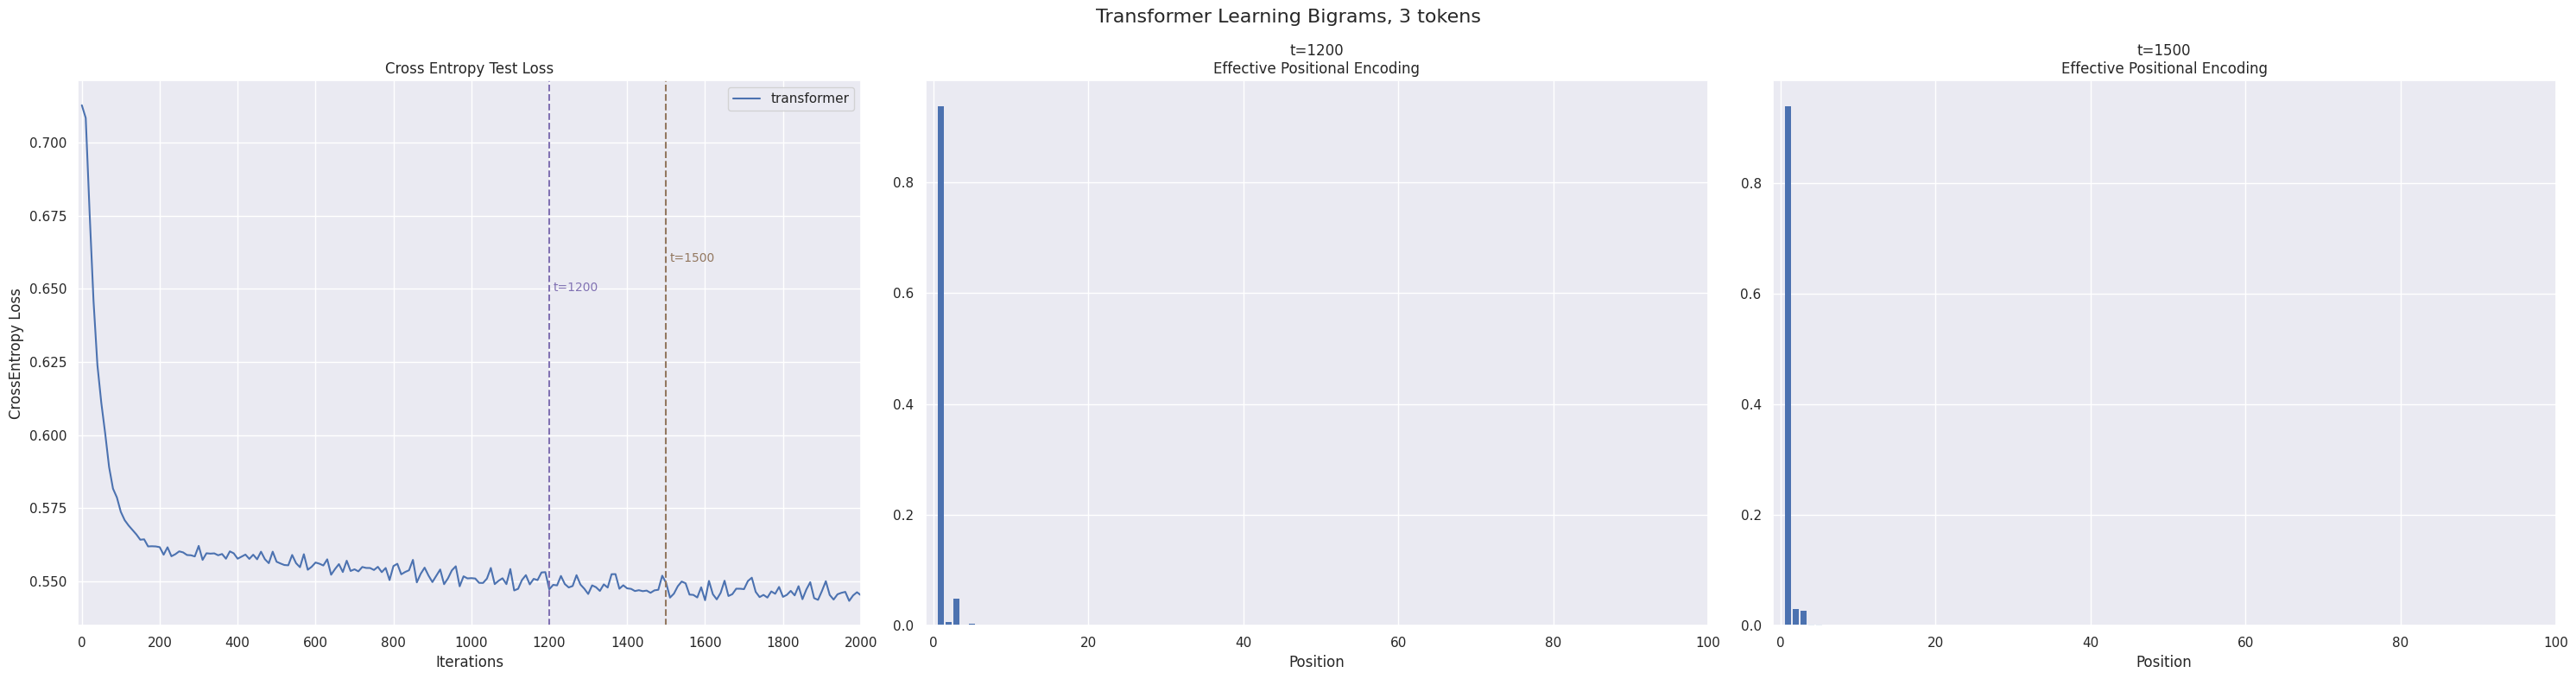

In [2]:
import numpy as np
import graphing_pipeline
import test_error
import importlib
import matplotlib
importlib.reload(test_error)
data_np = [t[0].numpy() for t in bigram_data]
colors = ['b', 'r', 'y', 'g', 'chocolate', 'purple']  #
colors = sns.color_palette()
points = [120,150]
# points = [1,10]
seed = 0
data = datem[seed]
model_history = histories[seed]
# Plotting
# plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(nrows=1, ncols=len(points)+1, figsize=(10 * len(points)+10, 8))
labels = ["uniform", "mean", "bigram", "trigram", "tetragram", "pentagram"]
# for i in range(len(data[1])):

#     dats = [dat[1][i] for dat in datem]
#     graphing_pipeline.data_to_line(dats, len(data[0]), labels[i], axes[0], colors[1+i])

# graphing_pipeline.data_to_curve([t[0].numpy() for t in datem], "Test Loss", colors[0])
# for dat in datem[1:]:
#     plt.plot(dat[0].numpy(), color = colors[0])
axes[0].plot(data[0].numpy(), color = colors[0], label="transformer")
# plt.plot(bigram_data[0].numpy(), color = colors[4], label="a=b OOD Test Loss")
# plt.plot(unigram_data[0].numpy(), color = colors[5], label="a=1-b OOD Test Loss")
# graphing_pipeline.data_to_curve([t[0].numpy() for t in bigram_data], "a=b OOD Test Loss", colors[4])
# graphing_pipeline.data_to_curve([t[0].numpy() for t in unigram_data], "a=1-b OOD Test Loss", colors[5])
# plt.xticks(range(0, len(model_history) + 1, len(model_history)//10), range(0,default.max_iters + 1, default.max_iters//10))
for i in range(len(points)):
    axes[0].axvline(points[i], color = colors[4+i], linestyle="--")
    label = f't={int((points[i])*default.max_iters/(len(model_history)-1))}'
    axes[0].text(points[i] + 1, axes[0].get_ylim()[1]*.9+.01 * (i%2), label, fontsize=10, color=colors[4+i])
axes[0].set_xlim(-1, 200)
plt.title(f'Two Layer Attention Only Transformer\n{len(histories)} runs')
axes[0].set_title(f'Cross Entropy Test Loss')
axes[0].set_xticks(range(0, len(model_history) + 1, len(model_history)//10), range(0,default.max_iters + 1, default.max_iters//10))
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('CrossEntropy Loss')
axes[0].legend()

pos_dat = test_error.pos_enc(model_history, default)
pos = torch.mean(pos_dat, dim = 0)
for i in range(len(points)):
    axes[i+1].bar(np.arange(len(pos)), pos[:,points[i]], width =0.8,edgecolor='none')
    axes[i+1].set_title(f't={int((points[i])*default.max_iters/(len(model_history)-1))}\nEffective Positional Encoding' )
    axes[i+1].set_xlim(-1, len(pos))
    axes[i + 1].set_xlabel("Position")
plt.suptitle("Transformer Learning Bigrams, 3 tokens", fontsize=16)
plt.tight_layout()
plt.show()

# plt.xticks(range(0, stop-start+1, 10), range(start,stop+1, (stop-start)//10))
# plt.ylabel("effective positional embeddings at 1")
# plt.xlabel("checkpoint")
# plt.legend()
# plt.show()



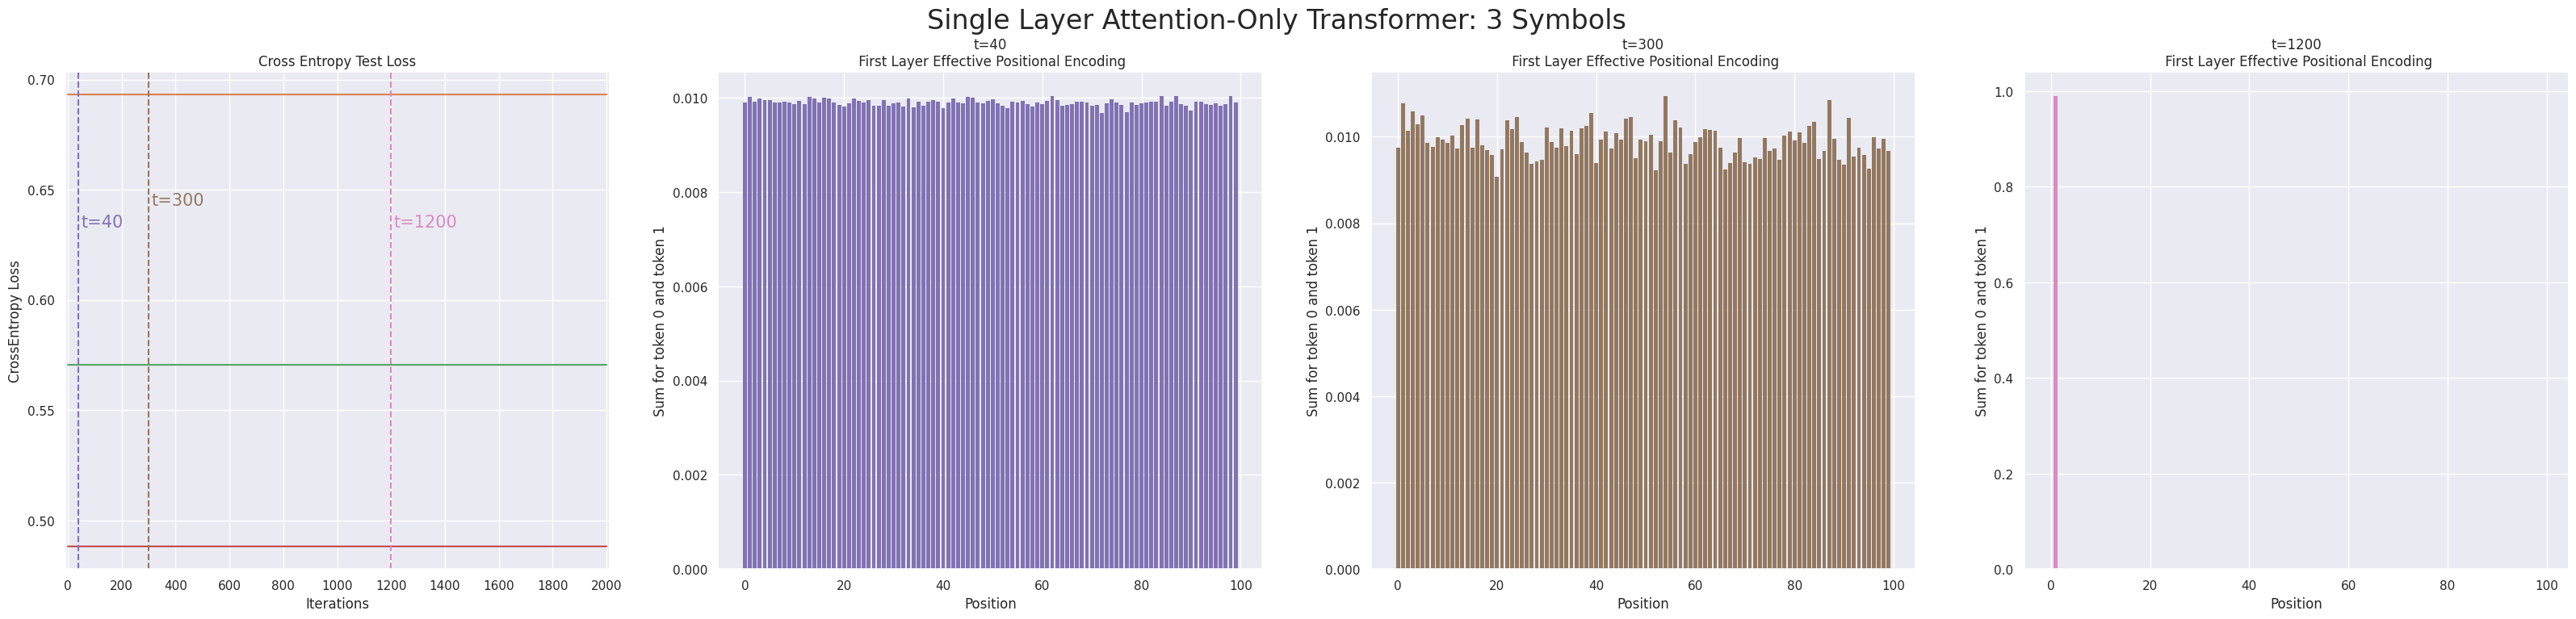

In [27]:
import numpy as np
import graphing_pipeline
import test_error
import importlib
import matplotlib
importlib.reload(test_error)
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'font.size': 20})
data_np = [t[0].numpy() for t in bigram_data]
colors = ['b', 'r', 'y', 'g', 'chocolate', 'purple']  #
colors = sns.color_palette()
points = [1,10,70,108, 180]
points = [4,30, 120]
seed = -1
data = datem[seed]
model_history = histories[seed]
# Plotting
# plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(nrows=1, ncols=len(points)+1, figsize=(10 * len(points)+10, 8))
labels = ["uniform", "mean", "bigram", "trigram", "tetragram", "pentagram"]
for i in range(len(data[1])):
    dats = [data[1][i] for dat in datem]
    graphing_pipeline.data_to_line(dats, len(data[0]), labels[i], axes[0], colors[1+i])
# axes[0].legend()

# graphing_pipeline.data_to_curve([t[0].numpy() for t in datem], "Test Loss", colors[0])
# for dat in datem[1:]:
#     plt.plot(dat[0].numpy(), color = colors[0])
axes[0].plot(data[0].numpy(), color = colors[0], label="transformer")
# axes[0].plot(bigram_data[0][0].numpy(), color = colors[4], label="a=b OOD Test Loss")
# axes[0].plot(unigram_data[0][0].numpy(), color = colors[5], label="a=1-b OOD Test Loss")
# graphing_pipeline.data_to_curve([t[0].numpy() for t in bigram_data], "a=b OOD Test Loss",axes[0], colors[4])
# graphing_pipeline.data_to_curve([t[0].numpy() for t in unigram_data], "a=1-b OOD Test Loss", axes[0], colors[5])
# plt.xticks(range(0, len(model_history) + 1, len(model_history)//10), range(0,default.max_iters + 1, default.max_iters//10))
for i in range(len(points)):
    axes[0].axvline(points[i], color = colors[4+i], linestyle="--")
    label = f't={int((points[i])*default.max_iters/(len(model_history)-1))}'
    axes[0].text(points[i] + 1, axes[0].get_ylim()[1]*.9+.01 * (i%2), label, fontsize=15, color=colors[4+i])
axes[0].set_xlim(-1, 201)
fig.suptitle(f'Single Layer Attention-Only Transformer: 3 Symbols')
axes[0].set_title(f'Cross Entropy Test Loss')
axes[0].set_xticks(range(0, len(model_history) + 1, len(model_history)//10), range(0,default.max_iters + 1, default.max_iters//10))
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('CrossEntropy Loss')

pos_dat = test_error.pos_enc(model_history, default)
# pos = torch.nn.functional.softmax(pos_dat[1]+pos_dat[0], dim=1)
# pos = torch.mean(pos_dat, axis=0)
pos = pos_dat[1] 
for i in range(len(points)):
    axes[i+1].bar(np.arange(len(pos)), pos[:,points[i]], width =0.8,edgecolor='none', color = colors[4+i])
    # axes[i+1].plot(np.fft.fft(pos[:,points[i]])[1:])
    axes[i+1].set_title(f't={int((points[i])*default.max_iters/(len(model_history)-1))}\n First Layer Effective Positional Encoding' )
    # axes[i+1].set_xlim(-1, len(pos))
    axes[i + 1].set_xlabel("Position")
    axes[i + 1].set_ylabel("Sum for token 0 and token 1")
plt.show()
    bigram_dataset = datasets.interpolate('test', 1, default.block_size+1, 2)
    unigram_dataset = datasets.interpolate('test', 0, default.block_size+1, 2)

# plt.plot([np.fft.fft(pos[:,i])[1]/np.mean(np.fft.fft(pos[:,i])) for i in range(pos.shape[1])])
# plt.xticks(range(0, stop-start+1, 10), range(start,stop+1, (stop-start)//10))
# plt.ylabel("effective positional embeddings at 1")
# plt.xlabel("checkpoint")
# plt.legend()
# plt.show()



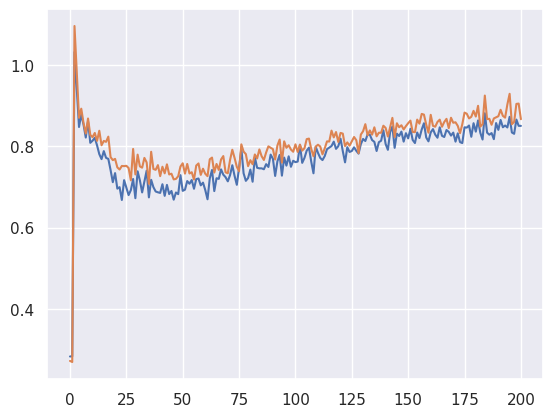

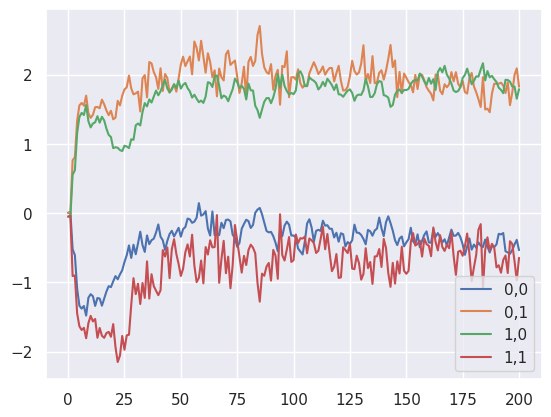

NameError: name 'rel' is not defined

In [9]:
with torch.no_grad():
    dat = torch.zeros(2,2,len(histories[0]))
    datv =  torch.zeros(2,len(histories[0]))
    for i in range(len(histories[0])):
        m = histories[0][i]
        embds = m.layers[0].ln(m.wte(torch.Tensor(list(range(2))).long().to(device)).float())
        dat[:,:, i] = (m.layers[0].Q(embds) @ m.layers[0].K((embds)).T)
        datv[:,i] = torch.norm(m.layers[0].V(embds), dim=1)
    # print(datv)
    plt.plot(datv[0].numpy())
    plt.plot(datv[1].numpy())
    plt.show()
    plt.plot(dat[0,0].numpy(), label = "0,0")
    plt.plot(dat[0,1].numpy(), label = "0,1")
    plt.plot(dat[1,0].numpy(), label = "1,0")
    plt.plot(dat[1,1].numpy(), label = "1,1")
    plt.legend()
    plt.show()
    import torch.nn.functional as F
    m = histories[0][-1]
    vt = F.softmax((m.layers[0].K(embds).cpu() @ rel.T), dim = 1)
    sns.heatmap(m.layers[0].c_proj(vt).cpu())
    plt.show()


In [17]:
model = histories[-1][-1]
with torch.no_grad():
    x = test_dataset[0][0].to(device)
    a = test_dataset[1][0].to(device)
    # inp = torch.stack([x])
    inp = x.unsqueeze(1)
    # x = torch.tensor([[0,1],[1,1],[0,0],[0,1]]*25, device = device)
    print(model(inp)[0])
    y_raw = model(inp)[0][0].squeeze()
    y = torch.argmax(y_raw, dim=1)
    print(torch.abs(y[1:]-x[:-1]).sum())
    mean = torch.tensor([torch.mode(x[:i+1])[0] for i in range(len(x))])
    print(torch.abs(y-x).sum())
    print((mean.cuda()-y).abs().sum())

tensor([[[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        [[ 1.3376, -1.3172]],

        [[-1.2450,  1.3511]],

        [[ 1.3376, -1.3172]],

        

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

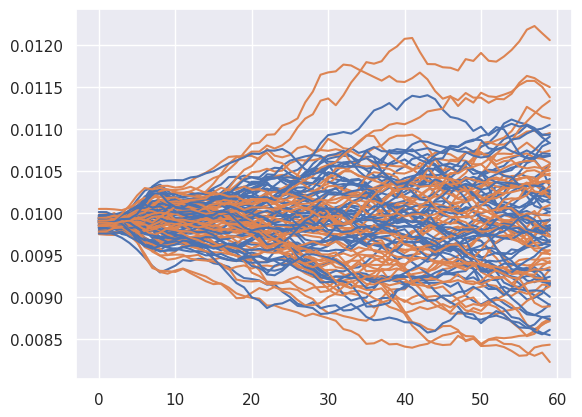

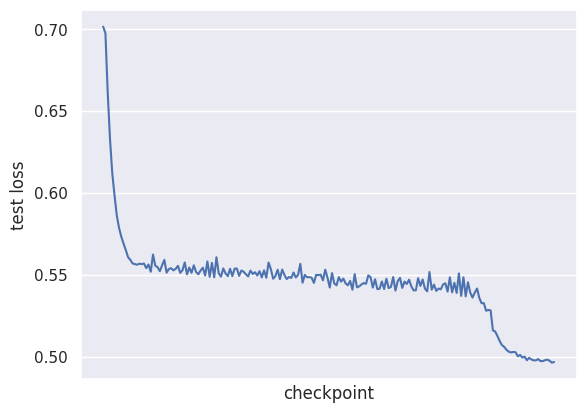

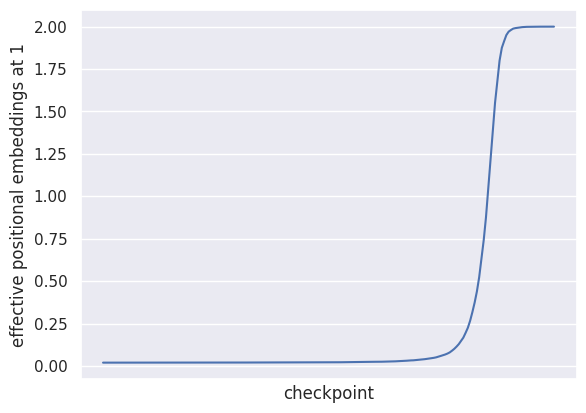

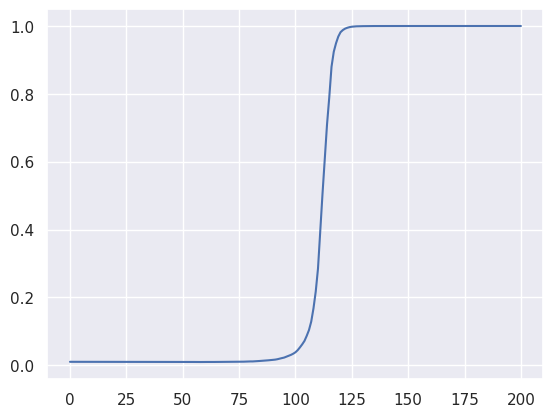

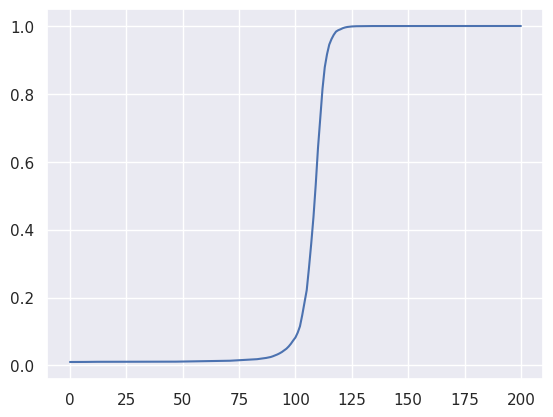

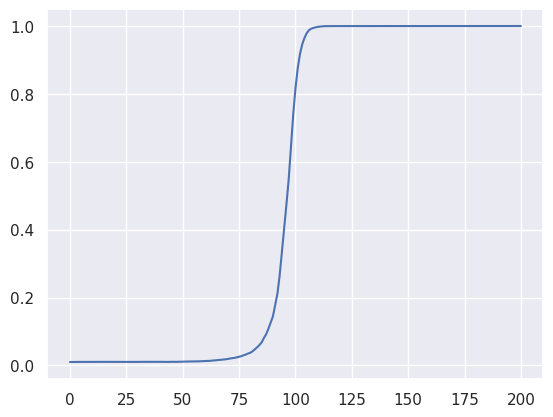

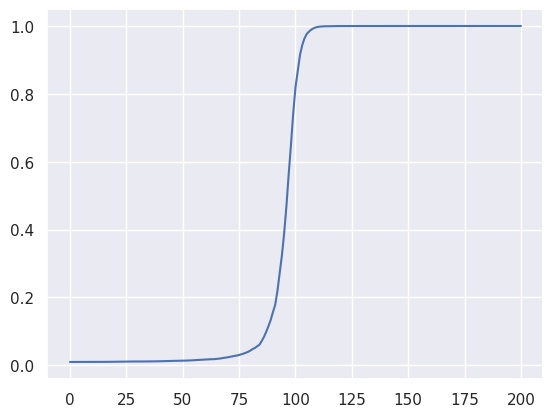

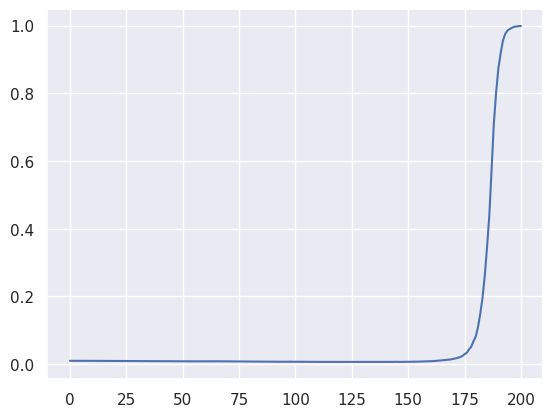

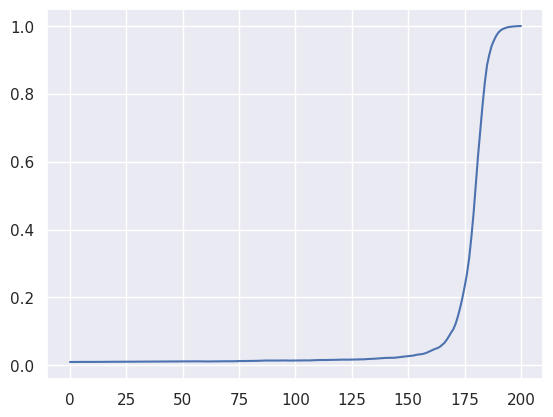

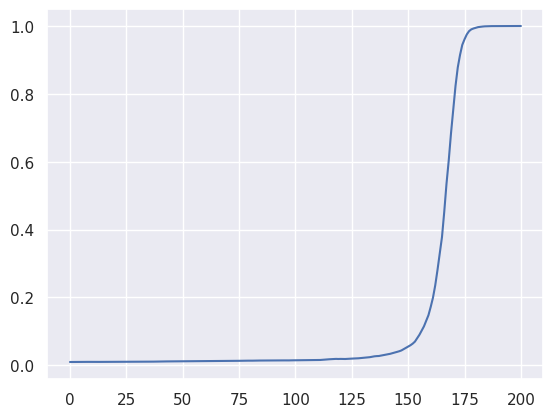

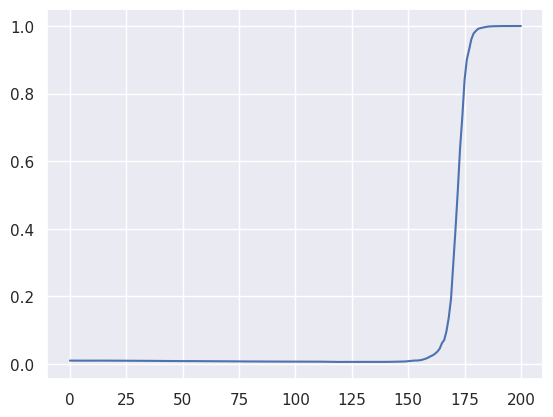

In [21]:
import importlib
import test_error
import matplotlib
importlib.reload(test_error)
pos_dat = test_error.pos_enc(model_history, default)
for i in range(len(pos_dat[1])):
    plt.plot(pos_dat[1][i,:60], color = sns.color_palette()[i%2])
plt.show()
# for dat in datem:
#     plt.plot(dat[0][25:75].numpy(), color = colors[0])
# plt.show()
start, stop = 0, -1
plt.plot(datem[-1][0][start:stop].numpy(), color = colors[0], label="test loss")
plt.xticks(range(0, stop-start+1, 10), range(start,stop+1, (stop-start)//10))
plt.ylabel("test loss")
plt.xlabel("checkpoint")
plt.show()
pos_dat = test_error.pos_enc(model_history, default)
plt.plot((pos_dat[1][1]+pos_dat[0][1])[start:stop], label = "sum")
plt.xticks(range(0, stop-start+1, 10), range(start,stop+1, (stop-start)//10))
plt.ylabel("effective positional embeddings at 1")
plt.xlabel("checkpoint")

for history in histories:
    pos_dat = test_error.pos_enc(history, default)

    # plt.plot((pos_dat[1][1]+pos_dat[0][1])[20:150], label = "sum")
    # plt.legend()
    # plt.show()
    for i in range(default.vocab_size):
        fig, ax = plt.subplots()
        # ax2 = ax.twinx()
        cmap = matplotlib.colormaps['rocket'], matplotlib.colormaps['crest'],sns.cubehelix_palette(as_cmap=True)
        ax.plot(pos_dat[i][1])
    
#     # for j in range(len(pos_dat[i])):
#     #     ax.plot(pos_dat[i][j], color = sns.color_palette()[j%2])#cmap[j%3](j /(len(KP_time)-99)))
#     # ax2.plot(data[0][:m, -1],label="loss", color= "blue")
#     # ax2.plot(data[4][:m, -1],label="zero loss", color= "red")
#     plt.show()

In [ ]:
interval = .1
datem = []
from utils import ngram_test, ngrams_context, special_compare_test
for n in np.arange(0,1+interval, interval):
    train_dataset = datasets.spectrum('train', n, length, num_tokens)
    model = Attention_Only_GPT(model_config)
    model_history = []
    train_loss = []

    trainer = Trainer(train_config, model, train_dataset)
    trainer.set_callback('on_batch_end', batch_end_callback)
    trainer.run()

    data = compare_test(model_history, test_dataset, num_tokens, trainer.device)
    datem.append(data)

number of parameters: 0.01M
running on device cuda


number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda
number of parameters: 0.01M
running on device cuda


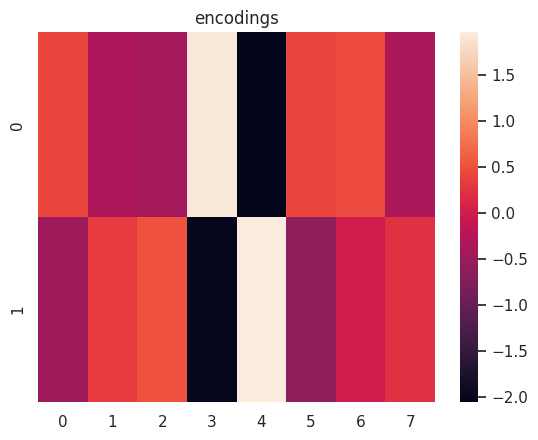

/tmp/ipykernel_34921/2818924211.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  att = F.softmax(att)


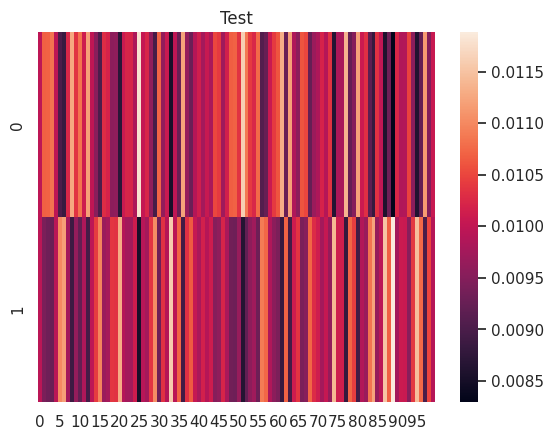

/tmp/ipykernel_34921/2818924211.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  KP = F.softmax(KP)


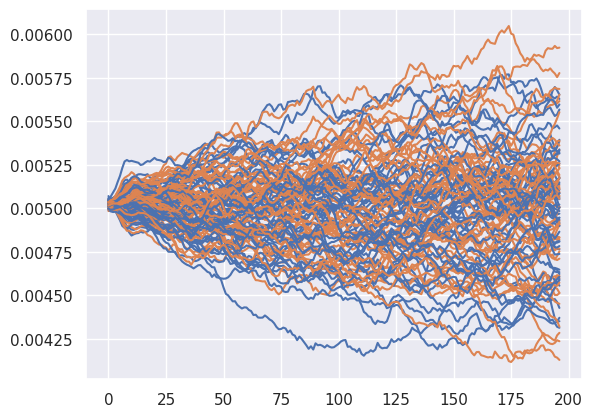

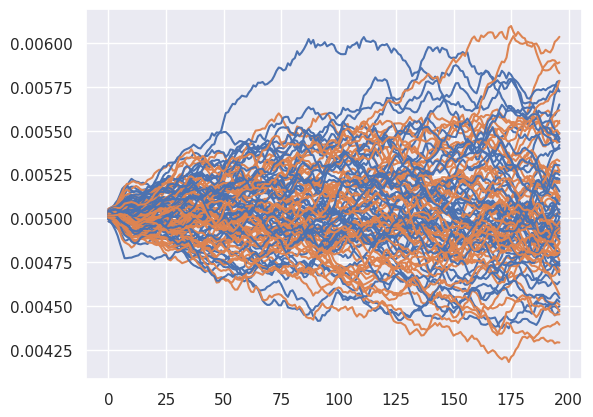

In [ ]:

import matplotlib
with torch.no_grad():
    t = 100
    m = model_history[-1]
    Q1 = m.transformer.h[0].attn.Q.weight.cpu()
    K1 = m.transformer.h[0].attn.K.weight.cpu()
    # embds = m.transformer.h[0].ln_1(F.one_hot(torch.Tensor([0,1]).long().to("cuda"),dim).float())
    embds = m.transformer.h[0].ln_1(m.transformer.wte(torch.Tensor(list(range(num_tokens))).long().to(trainer.device)).float())
    # embds = F.pad(m.transformer.h[0].ln_1(m.transformer.wte(torch.Tensor([0,1]).long().to("cuda"))).float(), (0,m.n_embd-m.n_embd//2))
    sns.heatmap(embds.cpu())
    plt.title("encodings")
    plt.show()

    # for i in [40, 45, 50, 55, 60]:

    #     embds = model_history[i].transformer.h[0].ln_1(model_history[i].transformer.wte(torch.Tensor([0,1]).long().to("cuda")).float())
    #     sns.heatmap(embds.cpu())
    #     plt.title(f"encodings {i}")
    #     plt.show()
    # sns.heatmap((Q1.T @ K1))
    # plt.show()
    pos = torch.arange(0, t, dtype=torch.long, device=trainer.device).unsqueeze(0)
    # pos = pos[50]
    pos_minus_one = []
    pos_zero = []
    rel = m.transformer.wpe[0].weight.cpu()[-100:]
    att = m.transformer.h[0].attn.K(embds).cpu() @ rel.T
    att = F.softmax(att)
    sns.heatmap(att)
    plt.title("Test")
    plt.show()

    KP_time = [[[] for i in range(199)] for j in range(num_tokens)]
    for m in model_history:
        rel = m.transformer.wpe[0].weight.cpu()
        # embds = m.transformer.h[0].ln_1(F.one_hot(torch.Tensor([0,1]).long().to("cuda"),dim).float())
        # embds = m.transformer.h[0].ln_1(m.transformer.wte(list(range(num_tokens)).long().to("cuda")).float())
        embds = m.transformer.h[0].ln_1(m.transformer.wte(torch.Tensor(list(range(num_tokens))).long().to(trainer.device)).float())

        # embds = F.pad(m.transformer.h[0].ln_1(m.transformer.wte(torch.Tensor([0,1]).long().to("cuda"))).float(), (0,m.n_embd-m.n_embd//2))
        for i in range(num_tokens):
            KP = (m.transformer.h[0].attn.K(embds).cpu() @ rel.T)[i]
            KP = F.softmax(KP)
            # KP_time.append(KP[99:102])
            for j in range(len(KP_time[i])):
                KP_time[i][j].append(KP[j])

    m=-1
    # ax.plot(pos_zero[:m], label="zero")
    # ax.plot(pos_minus_one[:m], label="minus 1")

    for i in range(num_tokens):
        fig, ax = plt.subplots()
        # ax2 = ax.twinx()
        cmap = matplotlib.colormaps['rocket'], matplotlib.colormaps['crest'],sns.cubehelix_palette(as_cmap=True)
        for j in range(len(KP_time[i])-99):
            ax.plot(KP_time[i][99+j][2:m], color = sns.color_palette()[j%2])#cmap[j%3](j /(len(KP_time)-99)))
        # ax2.plot(data[0][:m, -1],label="loss", color= "blue")
        # ax2.plot(data[4][:m, -1],label="zero loss", color= "red")
        plt.show()

    # m=55

    # fig, ax = plt.subplots()
    # ax2 = ax.twinx()
    # cmap = matplotlib.colormaps['rocket'], matplotlib.colormaps['crest']
    # for i in range(len(KP_time2)-99):
    #     ax.plot(KP_time2[99+i][2:m], color = cmap[i%2](i /(len(KP_time2)-99)))
    # ax2.plot(data[0][:m, -1],label="loss", color= "blue")
    # # ax2.plot(data[5][:m, -1],label="one loss", color= "red")
    # plt.show()
    
    KP_time = torch.tensor(KP_time)
    # Q2 = m.transformer.h[1].attn.Q.weight.cpu()
    # K2 = m.transformer.h[1].attn.K.weight.cpu()
    # sns.heatmap(Q2.T @ K2)
    # plt.show()

    

In [ ]:
# with torch.no_grad():
#     dataset = datasets.markov('test', length, num_tokens)
#     x, y = dataset[0]
#     idx = torch.stack([x])
#     e = model.token_embedding(idx) # shape b x t x k
#     e=e.to("cuda")
#     pos = torch.arange(model.length, dtype=torch.long, device="cuda")
#     pos = pos.view(-1,1) - pos.view(1, -1)
#     pos[pos<0] = 0
#     pos_embd = model.v(pos)[:, :, 0]
#     # print(pos_embd.shape, e.shape, (pos_embd @ e).shape)
#     # layer_one = torch.einsum(pos_embd, e, "Tt,btk->bTk")
#     layer_one = pos_embd @ e
#     K = model.Wk(layer_one)
#     attention = e @ K.transpose(1,2)
#     print(attention.shape)
#     sns.heatmap(attention[0].cpu())
#     plt.show()

#     assoc = (idx == idx.transpose(-1,-2))
#     print(assoc.shape)
#     sns.heatmap(assoc)
#     plt.show()
#     norm = attention[0] - attention[0].flatten().min()
#     norm /= norm.max()
#     sns.heatmap(assoc.float()[:,:-1] - norm[:,1:].cpu())

AttributeError: 'min_model' object has no attribute 'v'

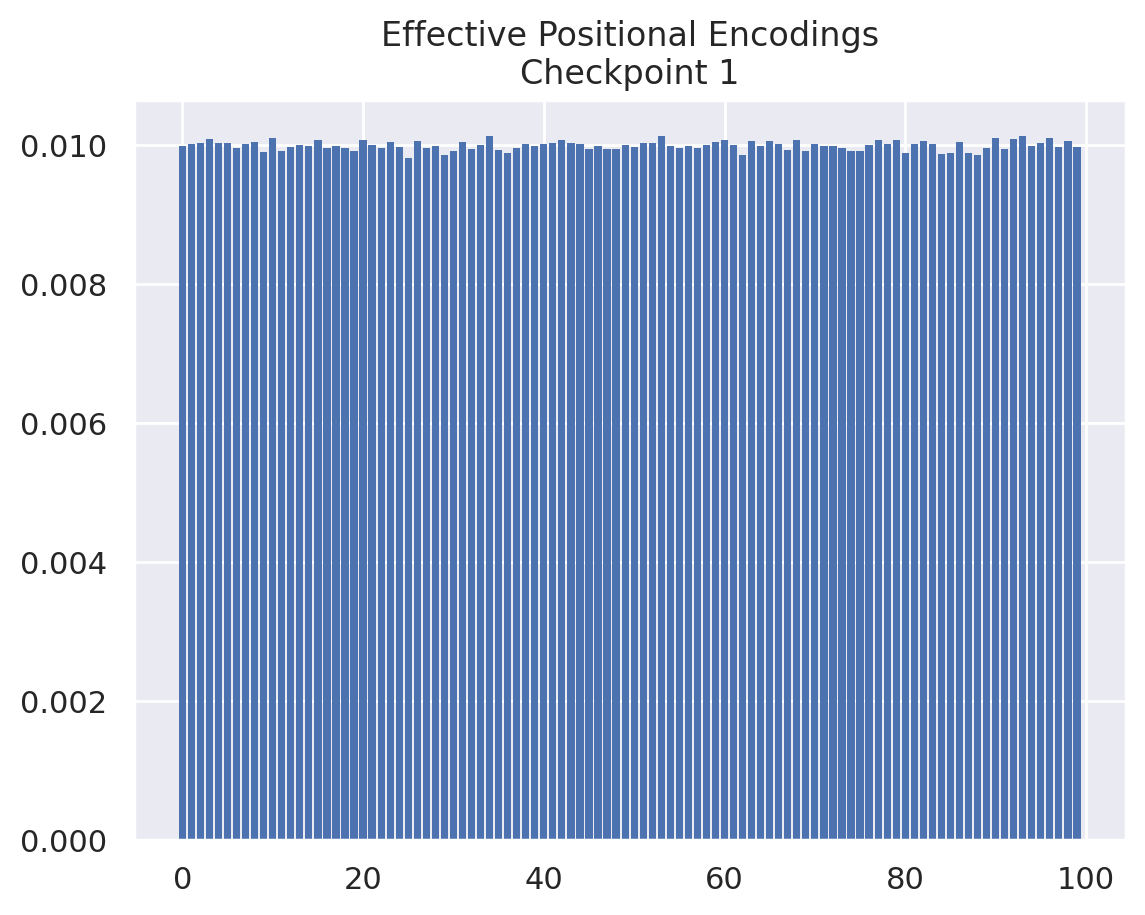

In [121]:

fig, ax = plt.subplots(dpi=200)
bar_width = 0.8
KP_time = pos_dat
bar_positions = np.arange(len(KP_time[1]))
# print(bar_positions)
bars = ax.bar(bar_positions, KP_time[1][:,0], edgecolor='none',width=bar_width)


def update(frame):
    ax.clear()
    ax.bar(bar_positions, KP_time[1][:,frame], edgecolor='none', width=bar_width)
    ax.set_title(f'Effective Positional Encodings\nCheckpoint {frame + 1}')
animation = FuncAnimation(fig, update, frames=len(KP_time[1][0]), interval=100, repeat=False)
# from IPython.display import HTML
# HTML(animation.to_jshtml())
# plt.show()
animation.save('animated_plot_a=b.gif', writer='imagemagick')

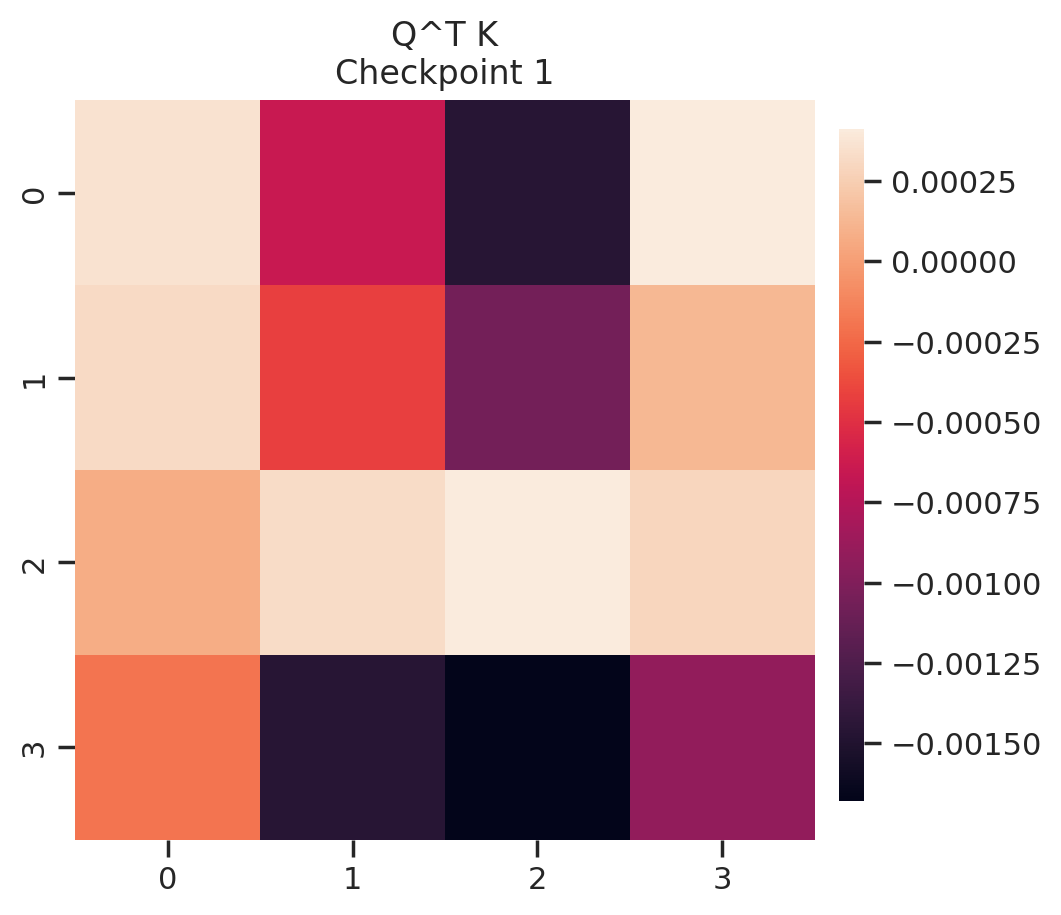

In [ ]:
with torch.no_grad():
    t = 100
    m = model_history[-1]
    Q = m.transformer.h[1].attn.Q.weight.cpu()
    K = m.transformer.h[1].attn.K.weight.cpu()
    V = m.transformer.h[0].attn.V.weight.cpu()
    # embds = m.transformer.h[0].ln_1(F.one_hot(torch.Tensor([0,1]).long().to("cuda"),dim).float())
    # embds = m.transformer.h[1].ln_1(m.transformer.wte(torch.Tensor([0,1]).long().to("cuda")).float())
    
    QK_time = []

    for m in model_history:

        # embds0 = m.transformer.h[0].ln_1(m.transformer.wte(torch.Tensor([0,0,1,1]).long().to("cuda")).float())
        # embds1 = m.transformer.h[0].ln_1(m.transformer.wte(torch.Tensor([0,1,0,1]).long().to("cuda")).float())
        Q = m.transformer.h[1].attn.Q.weight.cpu().T
        K = m.transformer.h[1].attn.K.weight.cpu().T
        # Q = m.transformer.h[1].attn.Q(embds).cpu()
        # K = m.transformer.h[1].attn.K(embds).cpu()
        V = m.transformer.h[0].attn.V.weight.cpu().T #+ torch.eye(len(K), device = K.device)
        QK = Q @ K.T
        # QK = F.softmax(QK)
        QK_time.append(QK)
        # QK_time.append(embds @ Q.T@K @embds.T)
    fig, ax = plt.subplots(dpi=200)
    cax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    def update(frame):
        ax.clear()
        cax.clear()
        sns.heatmap(QK_time[frame], annot=False,ax=ax, cbar_ax=cax, square=True)
        # ax.set_title(f'(V+I) Q^T K (V+I)^T\nCheckpoint {frame + 1}')
        ax.set_title(f'Q^T K\nCheckpoint {frame + 1}')
    animation = FuncAnimation(fig, update, frames=len(QK_time), interval=100, repeat=False)
    # from IPython.display import HTML
    # HTML(animation.to_jshtml())
    # plt.show()
    animation.save('QKmap1_'+"_".join(f'{k}:{exprm_config[k]}' for k in exprm_config)+".gif", writer='imagemagick')

In [ ]:
# # wte = deepcopy(model.transformer.wte)
# # wpe = deepcopy(model.transformer.wpe)
# # h = deepcopy(model.transformer.h)
# # # model.transformer.wte.apply(model._init_weights)
# # # model.transformer.h[0].apply(model._init_weights)
# # # model.transformer.wpe = wpe
# # # model.transformer.wte = wte
# # # model.transformer.h[0] = h[0]
# for param in model.transformer.h[1].parameters():
#     param.requires_grad = True

# for param in model.transformer.h[0].parameters():
#     param.requires_grad = False
# train_config = Trainer.get_default_config()
# train_config.max_iters = 10000
# train_config.num_workers = 6
# trainer = Trainer(train_config, model, train_dataset)
# def batch_end_callback2(trainer):
#     with torch.no_grad():
#       train_loss.append(trainer.loss.item())
#       if trainer.iter_num % max(train_config.max_iters//num_models, 1) == 0:
#         model_history.append(deepcopy(model))
#         # torch.save(model.state_dict(), os.path.join(path, 'checkpoints', f'model_{trainer.iter_num}'))
#     if trainer.iter_num % (train_config.max_iters// 5) == 0:
#         print(f"iter_dt {trainer.iter_dt *1000:.2f} ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
# trainer.set_callback('on_batch_end', batch_end_callback2)
# trainer.run()

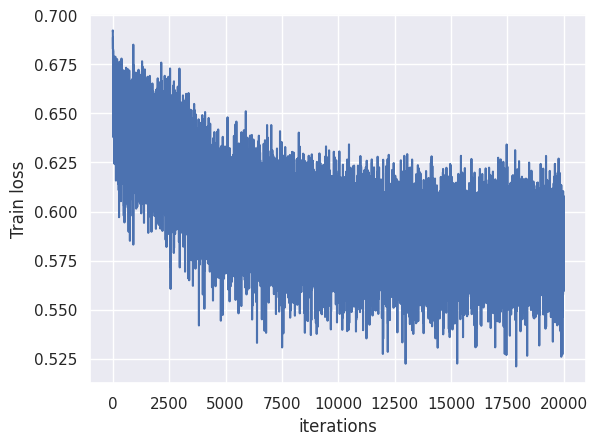

In [ ]:
plt.plot(train_loss)
plt.xlabel("iterations")
plt.ylabel("Train loss")
# plt.title(f"Training Loss \n"+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
plt.show()

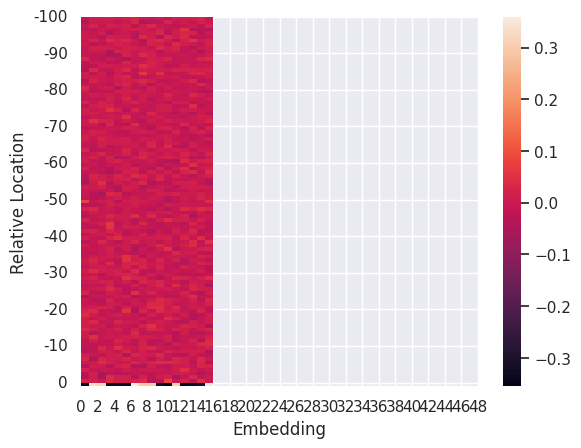

16


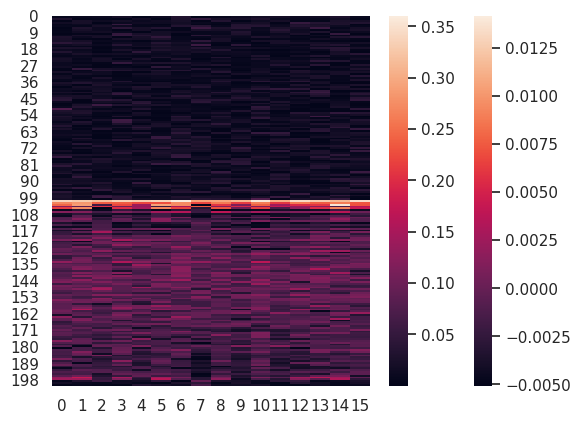

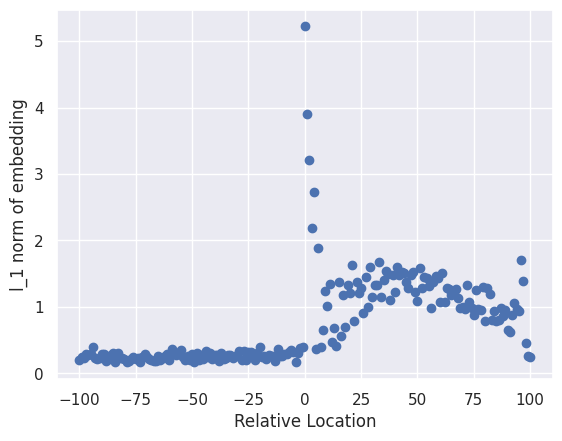

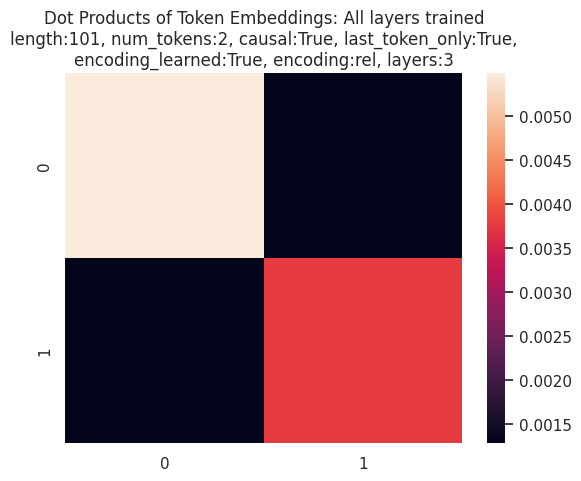

In [ ]:
with torch.no_grad():
    model.eval()
    if model_config.abs_embd:
        pos = torch.arange(0, length-1, dtype=torch.long, device=trainer.device).unsqueeze(0)
    else:
        pos = torch.arange(0, 2 * length-1, dtype=torch.long, device=trainer.device).unsqueeze(0)

    pos_encodings = model.transformer.wpe(pos).cpu()[0]

    sns.heatmap(pos_encodings[:length])
    plt.yticks( range(0, 101, 10), range(-100, 1, 10))
    plt.xticks(range(0, 50, 2), range(0, 50, 2))
    plt.xlabel("Embedding")
    plt.ylabel("Relative Location")
    plt.show()

    dim = pos_encodings.shape[1]
    print(dim)
    hmap = torch.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            hmap[i,j]= pos_encodings[i] @ pos_encodings[j]
    sns.heatmap(hmap)

    sns.heatmap(np.abs(pos_encodings))
    plt.show()
    plt.scatter(range(-100, 101), torch.sum(torch.abs(pos_encodings), axis=1))

    plt.xlabel("Relative Location")
    plt.ylabel("l_1 norm of embedding")
    plt.show()
    tokens = torch.arange(0, num_tokens, device = trainer.device)
    embeddings = model.transformer.wte(tokens).cpu()
    project = F.normalize(torch.rand((embeddings.shape[1], 2)), dim=1)
    hmap = torch.zeros((num_tokens, num_tokens))
    for i in range(num_tokens):
        for j in range(num_tokens):
            hmap[i,j]= embeddings[i] @ embeddings[j]
    sns.heatmap(hmap)
    plt.title("Dot Products of Token Embeddings: All layers trained\n"+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
    plt.show()
    model.train()

In [4]:
import utils
# importlib.reload(utils)
from utils import top_k_accuracy
from utils import ngram_test, ngrams_context, special_compare_test
import datasets
# test_dataset = datasets.spectrum('test', 0, length, num_tokens)
length, num_tokens = 101, 2
test_dataset = datasets.ngrams('test', 2,length, num_tokens)
if "datem" not in locals():
    datem = []
# datem.append(compare_test(model_history, datasets.spectrum('test', 1, length, num_tokens),2, trainer.device))
# datem.append(compare_test(model_history, datasets.spectrum('test', 0, length, num_tokens),2, trainer.device))
test_dataset = datasets.ngrams('test', 2,length, num_tokens)
data= ngrams_context(model_history, test_dataset, "cuda")

datem.append(data)
# data = top_k_accuracy(model_history, test_dataset, num_tokens, trainer.device)
# print(data.shape)


/home/ezrae/Documents/phasetransitions/.venv/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/home/ezrae/Documents/phasetransitions/utils.py:326: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits[:,-1])


In [1]:
import matplotlib 
import seaborn as sns
cmap = matplotlib.colormaps['rocket']
sns.set_theme(style="ticks")
fig, ax = plt.subplots()
# ax2 = ax.twinx()
# sns.set_palette("tab10")
# for i in range(1000, len(model_history), 1000):
#     ax.plot(data[0][i:i+1000, -1], label=f"model with first attention layer reset {i//1000} times")
colors = sns.color_palette("tab10", test_dataset.n+3)
m = 0
for dat in datem:
    ax.plot(datem[0][0], label = "model")
# ax.plot(data[0], label = "old model", color = colors[-1])
# ax.plot(datem[0][0], label = "model", color = colors[0])
print(test_dataset.n)
for n in range(0,test_dataset.n+2):
    ax.plot((data[1][n],)*len(data[0]), label = str(n)+"-gram on context", color = colors[n+1])
lab = 20
plt.xticks(range(0, len(model_history) + 1, lab), range(0,train_config.max_iters + 1, train_config.max_iters//len(model_history)*lab))
plt.grid()
h1, l1 = ax.get_legend_handles_labels()
ax.legend(h1, l1, loc="upper right", prop={'size': 8})
ax.set_xlabel(f"iterations")
ax.set_ylabel("Test loss at last token")
plt.title(f"In-context learning of "+str(n)+"grams: test loss\n"+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
plt.show()
plt.grid()

# plt.plot(data[3], label=f"KL Div between model and ground truth", color=colors[0])
for n in range(1,test_dataset.n+2):
    plt.plot(data[2][n], label = f"KL Div with {n}grams", color = colors[n+1])
# for n in range(1, test_dataset.n+2):
#     plt.plot((data[4][n],)*len(data[0]), label = f"Symmetric KL Div between {n}grams and truth", linestyle="--", color = colors[n+1])

plt.xticks(range(0, len(model_history) + 1, lab), range(0,train_config.max_iters + 1, train_config.max_iters//len(model_history)*lab))
plt.legend(loc="upper right", prop={'size': 6})
plt.xlabel(f"iterations")
plt.ylabel("KL Div")
plt.title(f"{n}grams Symmetric KL Div/Mutual Information\n"+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
plt.show()
print(data[-1])

NameError: name 'plt' is not defined

200


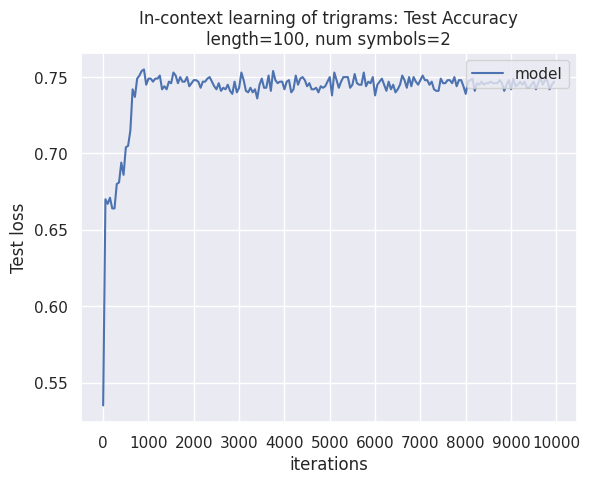

In [ ]:
# plt.plot(data[0][-1], label = "model")
plt.plot([dat[-1] for dat in data], label = "model")
print(len(data))
# plt.plot(data[-1], label = "model")
# plt.plot(data[1], label = "bigrams on context")
# plt.plot(data[2], label = "unigrams on context")
# plt.plot(data[3], label = "uniform distribution")
# plt.plot(data[7], label = "stationary distribution")
plt.legend(loc="upper right")
lab = 20
plt.xticks(range(0, len(model_history) + 1, lab), range(0,train_config.max_iters + 1, train_config.max_iters//len(model_history)*lab))
plt.xlabel("iterations")
plt.ylabel("Test loss")
plt.title(f"In-context learning of trigrams: Test Accuracy\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()

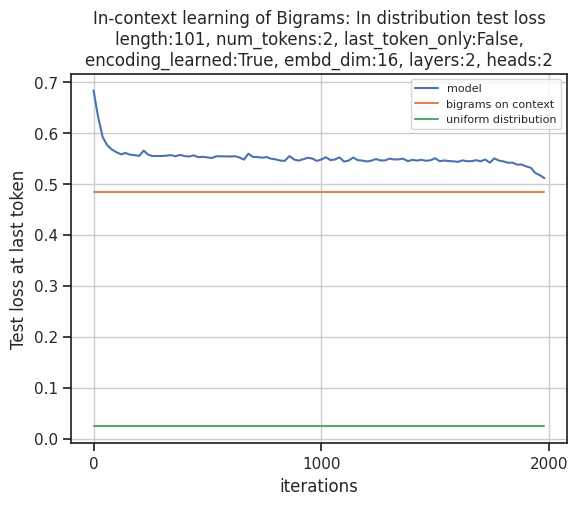

IndexError: too many indices for tensor of dimension 1

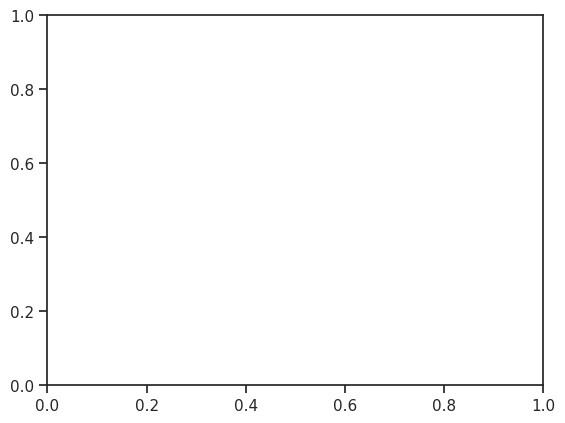

In [ ]:
token = -1
cmap = matplotlib.colormaps['rocket']
sns.set_theme(style="ticks")
fig, ax = plt.subplots()
# ax2 = ax.twinx()
# sns.set_palette("tab10")
# for i in range(1000, len(model_history), 1000):
#     ax.plot(data[0][i:i+1000, -1], label=f"model with first attention layer reset {i//1000} times")
m = 0
# for d in range(0,len(datem)):
#     ax.plot(datem[d][0][m:, -1], label = f"model n={d*1/(len(datem)-1)}",color = sns.color_palette("Blues", as_cmap=True)((3+d)/(len(datem)-1+3)))
ax.plot(datem[-1][0][m:], label = "model",)
# ax.plot(datem[0][0][m:], label = "model loss on a=b",)
# ax.plot(datem[1][0][m:,-1], label = "model loss on a=1-b",)
ax.plot((datem[-1][1][token],)*len(data[0][m:]), label = "bigrams on context")
# ax.plot((data[2][token],)*len(data[0][m:]), label = "unigrams on context")
# ax.plot((datem[-2][2][token],)*len(data[0][m:]), label = "unigrams on context in direchlet")
ax.plot((datem[-1][3][token],)*len(data[0][m:]), label = "uniform distribution")
# ax.plot((data[7][token],)*len(data[0][m:]), label = "stationary distribution")
# for n in range(2,test_dataset.n+1):
#     ax.plot((data[8][n-2][token],)*len(data[0][m:]), label = str(n+1)+"-gram on context")
lab = 50
plt.xticks(range(0, len(model_history) + 1, lab), range(0,train_config.max_iters + 1, train_config.max_iters//len(model_history)*lab))
plt.grid()
# print(len(range(0, train_config.max_iters, train_config.max_iters//num_models)))
# ax.axvline(250, color = "red", label ="swap layer being trained")
# attention = torch.tensor(attention)
# ax2.plot(attention, label = "attention", color = "black")
h1, l1 = ax.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# ax.legend(h1+h2, l1+l2, loc="upper right", prop={'size': 8})
ax.legend(h1, l1, loc="upper right", prop={'size': 8})
ax.set_xlabel(f"iterations")
# ax.set_xlabel("checkpoints")
ax.set_ylabel("Test loss at last token")
# ax2.set_ylabel("Sum of attention not on diagonal")
plt.title(f"In-context learning of Bigrams: In distribution test loss\n"+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
# plt.title(f"In-context learning of Markov Chain: test loss\n W_k only minimal model, SGD\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()


fig, ax = plt.subplots()
# ax2 = ax.twinx()
early_token = 90
ax.plot(data[0][:, :].mean(dim=1), label = "model")
# ax.plot((data[1][-1]- data[1][early_token],)*len(data[0]), label = "bigrams on context")
# ax.plot((data[2][-1]- data[2][early_token],)*len(data[0]), label = "unigrams context")
# ax2.plot(attention, label = "attention", color ="black")
# plt.plot((data[3][-1]- data[3][10],)*len(data[0]), label = "uniform")
# plt.legend(loc="upper right")
ax.set_xlabel(f"{train_config.max_iters//1000} iterations")
ax.set_ylabel(f"Test loss at last token minus loss averaged over all tokens")
# ax2.set_ylabel("Sum of attention not on diagonal")
# plt.title(f"In-context learning of Markov Chain: In-Context loss\n "+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
plt.title(f"In-context learning of Markov Chain: In-context loss\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()


plt.plot(data[0][-1], label = "model")
plt.plot(data[1], label = "bigrams on context")
plt.plot(data[2], label = "unigrams on context")
plt.plot(data[3], label = "uniform distribution")
# plt.plot(data[7], label = "stationary distribution")
plt.legend(loc="upper right")
plt.xlabel("token")
plt.ylabel("Test loss")
plt.title(f"In-context learning of Markov Chain: test loss\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()

plt.plot(data[0][-1]/data[1])
plt.plot(data[3]/data[1], label = "uniform distribution")
plt.xlabel("token")
plt.ylabel("Test loss")
plt.title(f"In-context learning of Markov Chain: distance from bayes optimal\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()
cmap = matplotlib.colormaps['rocket']

# sns.set_palette("rocket_r")
for i in range(0, len(data[0]), 5):
    plt.plot(data[0][i], label = "model", color = cmap(i /len(data[0])))
plt.plot(data[1], label = "bigrams on context", color = "green")
# plt.plot(data[2], label = "unigrams on context")
# plt.plot(data[3], label = "uniform distribution")
# plt.plot(data[7], label = "stationary distribution")
# plt.legend(loc="upper right")
plt.xlabel("token")
plt.ylabel("Test loss")
plt.title(f"In-context learning of Markov Chain: test loss\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()

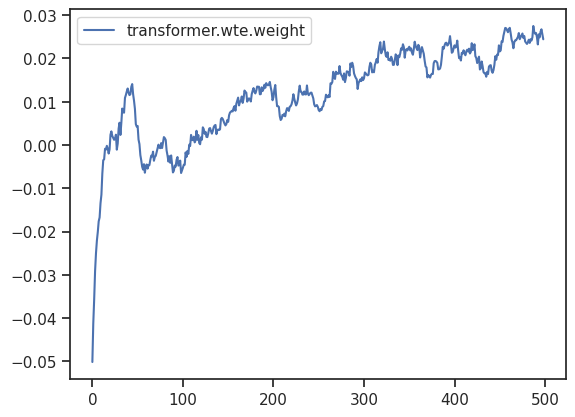

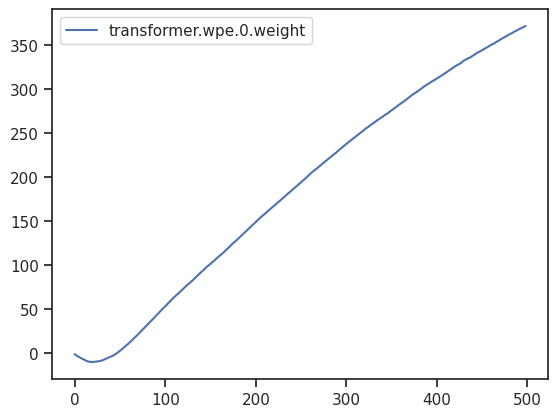

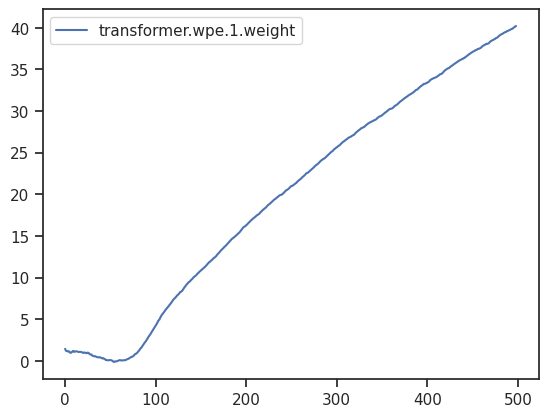

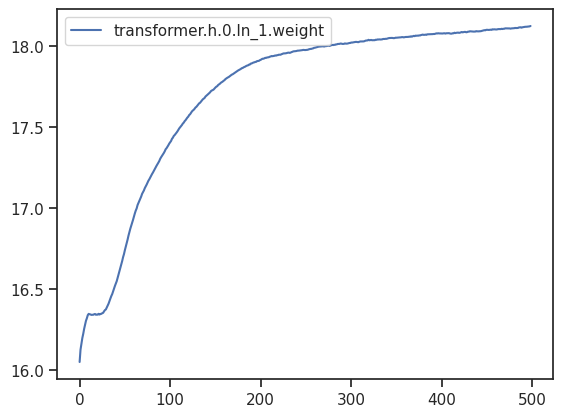

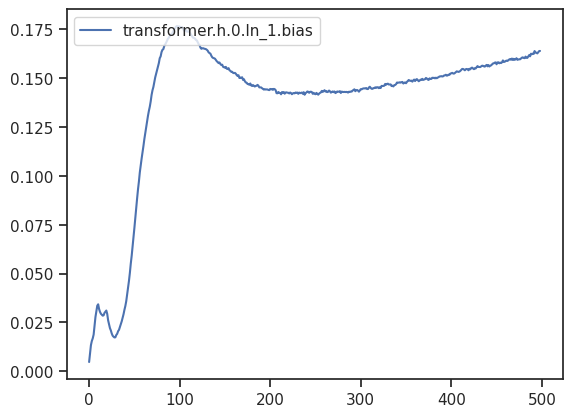

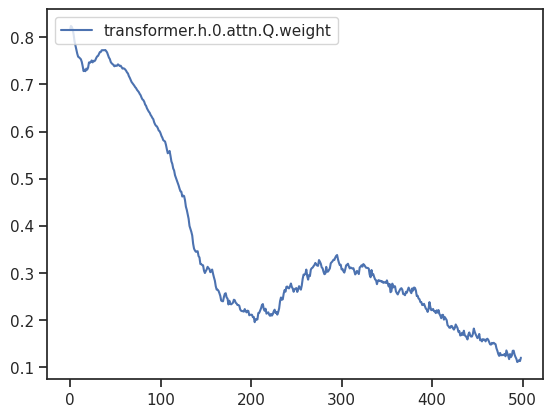

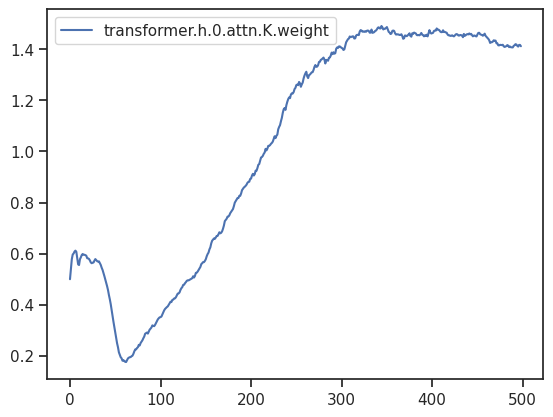

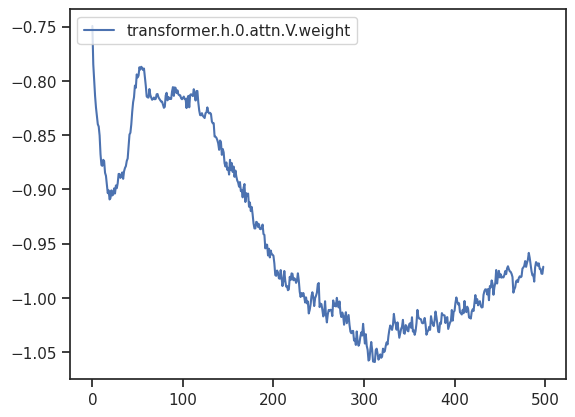

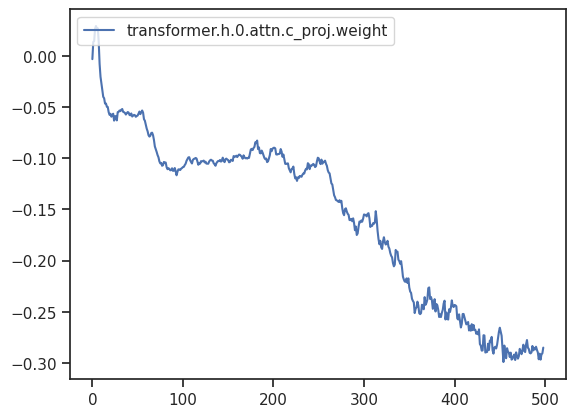

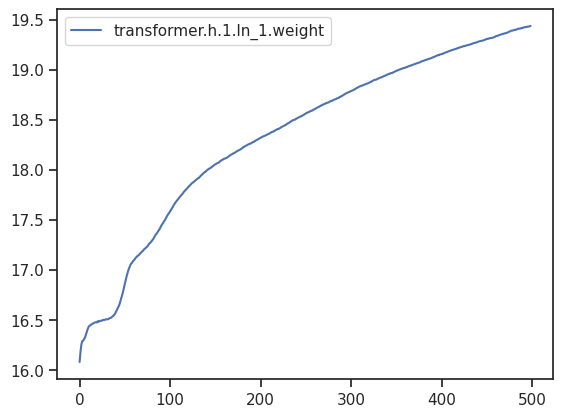

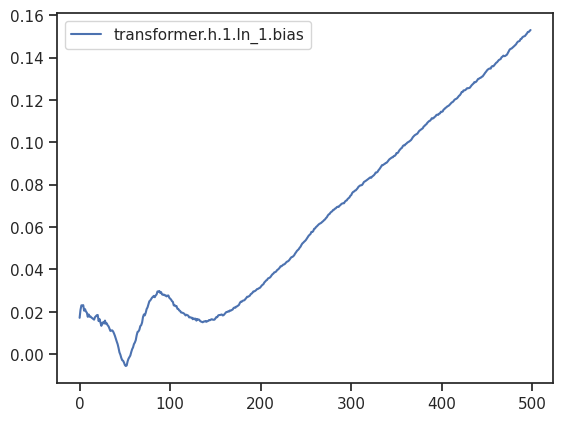

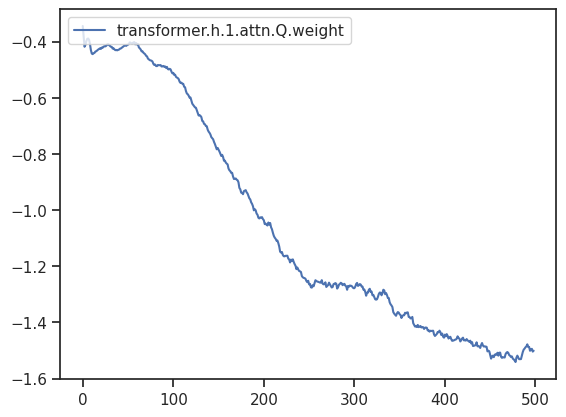

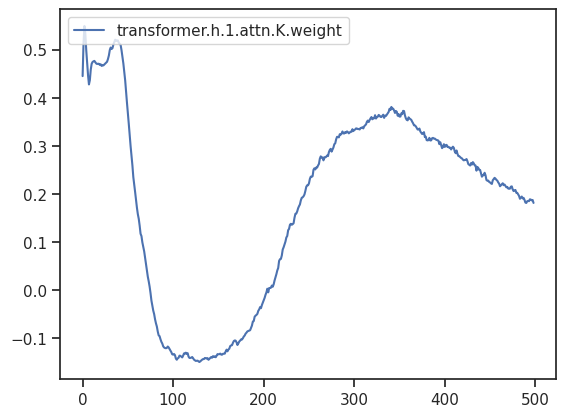

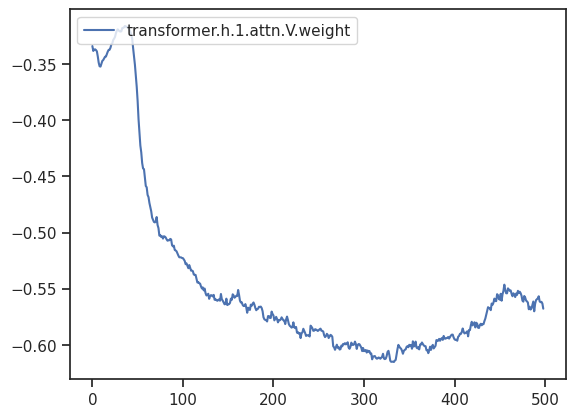

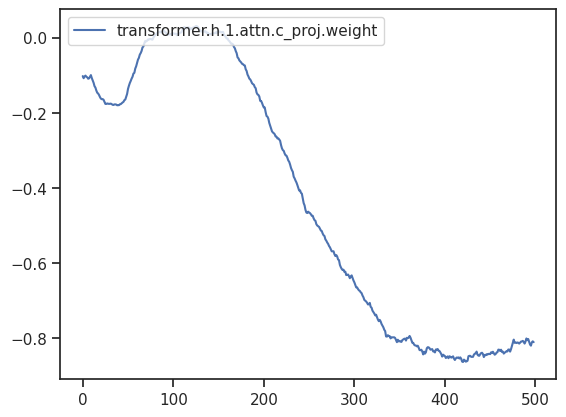

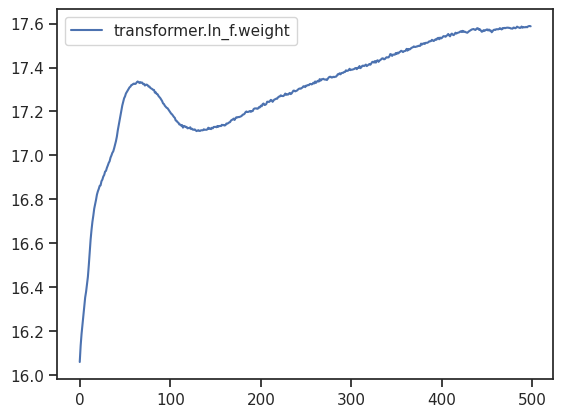

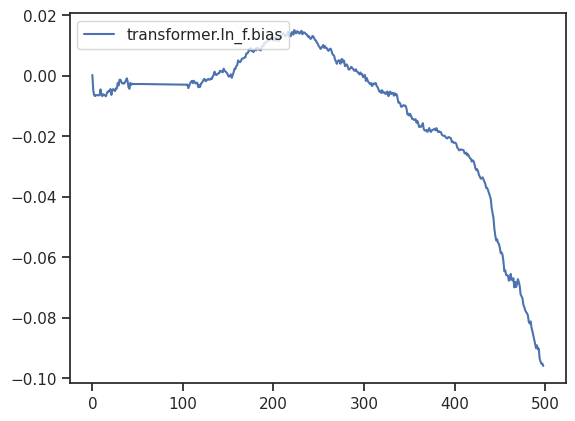

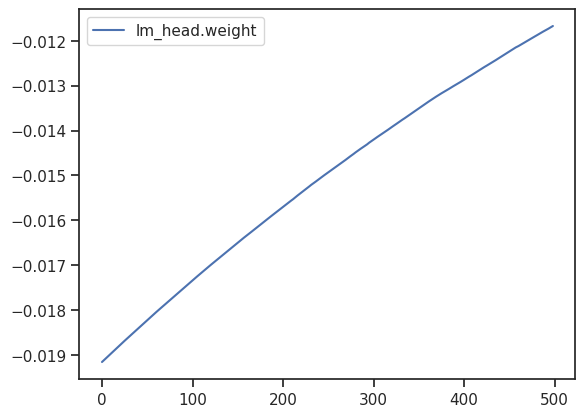

AttributeError: 'Attention_Only_GPT' object has no attribute 'layer_two'

In [ ]:
with torch.no_grad():
    plots = {param[0]:[] for param in model.named_parameters()}
    for i in range(len(model_history)-1):
        params, old_params = list(model_history[i+1].named_parameters()), list(model_history[i].named_parameters())
        for k in range(len(plots)):
            plots[list(plots)[k]].append(torch.sum((params[k][1])).cpu())


    fig, ax = plt.subplots()
    for k in list(plots):
        plt.plot(plots[k], label=k)
        plt.legend(loc="upper left",)
        plt.show()
    # ax2 = ax.twinx()
    # ax2.plot(data[0][:, -1], label = "model", color="gray")
    # # ax2.plot(10,9, color="red")
    # h1, l1 = ax.get_legend_handles_labels()
    # h2, l2 = ax2.get_legend_handles_labels()
    # ax.legend(h1+h2, l1+l2, loc="upper right", prop={'size': 9})
    # lab = 100
    # plt.xticks(range(0, len(model_history) + 1, lab), range(0,train_config.max_iters + 1, train_config.max_iters//len(model_history)*lab ))
    # plt.title(f"In-context learning of Markov Chain: l1 norm of changes in weights\nLR=0.01 length={train_dataset.length}, num symbols={train_dataset.num_symbols}")
    # plt.show()
    # print(model.v.weight.cpu().size())

    # sns.heatmap(torch.stack([m.v.weight.cpu()[:,0] for m in model_history][:]))

    # plt.plot(torch.stack([m.v.weight.cpu()[2,0] for m in model_history]))
    # sns.heatmap(model_history[-1].layer_one.Wv.weight.cpu())
    # plt.plot(model_history[-1].layer_one.v.weight.cpu())
    # plt.show()
    # sns.heatmap(model_history[-1].layer_two.Wk.weight.cpu() @ model_history[-1].layer_two.Wq.weight.cpu().T)
    sns.heatmap(model_history[-1].layer_two.Wq.weight.cpu())
    plt.show()
    sns.heatmap(model_history[0].layer_one.Wk.weight.cpu())
    plt.show()
    sns.heatmap(model_history[-1].layer_one.Wk.weight.cpu())
    plt.show()
    # sns.heatmap(torch.stack([m.Wk.weight.cpu().flatten() for m in model_history])[:,:])
    # sns.heatmap(model_history[25].layer_two.Wk.weight.cpu())
    plt.show()
    # model_history[-1].layer_one.v.weight.data[20:50]=model_history[-2].layer_one.v.weight.data[20:50]
    print(model_history[-2].layer_one.v.weight.data)
    # for i in range(1,9):
    #     model_history.append(deepcopy(model_history[-1]))
    #     model_history[-1].layer_one.v.weight.data[-10 * i:] = 0

In [ ]:
# for i in range(9):
wte = deepcopy(model.transformer.wte)
wpe = deepcopy(model.transformer.wpe)
model.apply(model._init_weights)
trainer.run()
model.transformer.wpe = wpe
# model.transformer.wte = wte

iter_dt 14.98 ms; iter 0: train loss 0.69436


KeyboardInterrupt: 

In [1]:
from mingpt.model_new import Attention_Only_Transformer
import training_pipeline
import torch
import test_error
import torch.nn as nn
import torch.nn.functional as F
import datasets
from mingpt.utils import set_seed
set_seed(0)
config = training_pipeline.get_default_config()
k = 2
config.vocab_size = k
config.device = "cuda:0"
config.n_embd = k * 3
device = config.device

def remodel(model):
    model.eval()
    # a = 1.68
    # b = -1.75 # 0.02
    # a = 3
    # b = -5/2 # .009
    a = 2.5
    b = -.75 # .004 #k=10:.008
    # a = 222254/78433
    # b = -143821/156866 # .007
    a = 1
    b = 0
    model.wte.weight = nn.Parameter(torch.zeros_like(model.wte.weight))
    model.wte.weight[:k,:k] = torch.eye(k)
    model.lm_head.weight  = nn.Parameter(torch.zeros_like(model.lm_head.weight))
    model.lm_head.weight[:k,2*k:3*k] = a *  torch.eye(k)
    model.lm_head.weight[:k,:k] = -b * torch.ones((k,k))

    model.ln_f = nn.Identity()

    c = 500000
    model.layers[0].wpe.weight = nn.Parameter(torch.zeros_like(model.layers[0].wpe.weight))
    model.layers[0].wpe.weight[1] = torch.ones_like(model.layers[0].wpe.weight[1])
    model.layers[0].Q.weight = nn.Parameter(torch.zeros_like(model.layers[0].Q.weight))
    model.layers[0].K.weight = nn.Parameter(torch.zeros_like(model.layers[0].Q.weight))
    model.layers[0].K.weight[:k,:k] = c * torch.eye(k)
    model.layers[0].V.weight = nn.Parameter(torch.zeros_like(model.layers[0].Q.weight))
    model.layers[0].V.weight[k:2 * k,:k] = torch.eye(k)
    model.layers[0].c_proj.weight = nn.Parameter(torch.eye(config.n_embd, device = device))
    model.layers[0].ln = nn.Identity()
    model.layers[0].attn_dropout = nn.Identity()
    model.layers[0].resid_dropout = nn.Identity()
    model.layers[0].embd_dropout = nn.Identity()

    model.layers[1].wpe.weight = nn.Parameter(torch.zeros_like(model.layers[1].wpe.weight))
    model.layers[1].Q.weight = nn.Parameter(torch.zeros_like(model.layers[0].Q.weight))
    model.layers[1].Q.weight[:k,:k] = c * torch.eye(k)
    model.layers[1].K.weight = nn.Parameter(torch.zeros_like(model.layers[0].Q.weight))
    model.layers[1].K.weight[:k,k:2 * k] = torch.eye(k)
    model.layers[1].V.weight = nn.Parameter(torch.zeros_like(model.layers[0].Q.weight))
    model.layers[1].V.weight[2*k:3*k,:k] = torch.eye(k)
    model.layers[1].c_proj.weight = nn.Parameter(torch.eye(config.n_embd, device = device))
    model.layers[1].ln = nn.Identity()
    model.layers[1].attn_dropout = nn.Identity()
    model.layers[1].resid_dropout = nn.Identity()
    model.layers[1].embd_dropout = nn.Identity()

model = Attention_Only_Transformer(config)

with torch.no_grad():
    
    
    model = model.to(device)
    remodel(model)
    test_dataset = datasets.ngrams("test", 2, num_symbols = k)

    data = test_error.test_last_token([model], test_dataset, device)
    print(f"loss = {data[0][0]} bar is at {data[1].tolist()}")


    # x = torch.tensor([1]+[0]*99, device = device)
    x = test_dataset[0][0].to(device)
    idx = torch.stack([x])
    b, t = idx.size()
    tok_emb = model.wte(idx) # token embeddings of shape (b, t, n_embd)

    y = model.layers[0](model.drop(tok_emb))
    print(x)
    # print(y)
    residual = y[0,:,:k].max(axis = 1)[1]
    print(f"residual looks good: {(x==residual).all().item()} and {k!=2 or (y[0,:,k]-y[0,:,k+1]).abs().min()>.95}")
    # print((y[0,:,k]-y[0,:,k+1]))
    before = y[0,:,k:2 * k].max(axis = 1)[1]
    print(f"no random values: {y[0,:,2 * k:].max().item() == 0}")
    print(f"first layer correct: {(x[:-1]==before[1:]).all().item()}")
    self = model.layers[1]
    
    B, T, C = y.size()
    K = self.K(y).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
    Q = self.Q(y).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
    V = self.V(y).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

    import math
    # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
    attn = (Q @ K.transpose(-2, -1)) * (1.0 / math.sqrt(K.size(-1)))
    attn = attn.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
    attn = F.softmax(attn, dim=-1)
    print(attn.max())

    y = model.layers[1](y).squeeze()
    # print(f"no random values: {y[:,2 * k:].max().item() == 0}")
    start = 90
    print(torch.tensor([test_error.ngram(x[:i+1], k, 2)[0] for i in range(start,len(x))]))
    # def norm(x):
    #     return x/x.sum(dim=1)[:,None].expand(-1,2)
    # print(y[start:,:k])
    # print(model(idx)[0][0,start:,:k])
    # # print(F.softmax(y[:,:k], dim=1)[start:, 0])

    


number of parameters: 1560


tensor([[     0.,      0., 500000.,      0.,      0.,      0.],
        [     0.,      0.,      0., 500000.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.]],
       device='cuda:0')


AttributeError: 'Attention_Only_Transformer' object has no attribute 'resid_dropout'

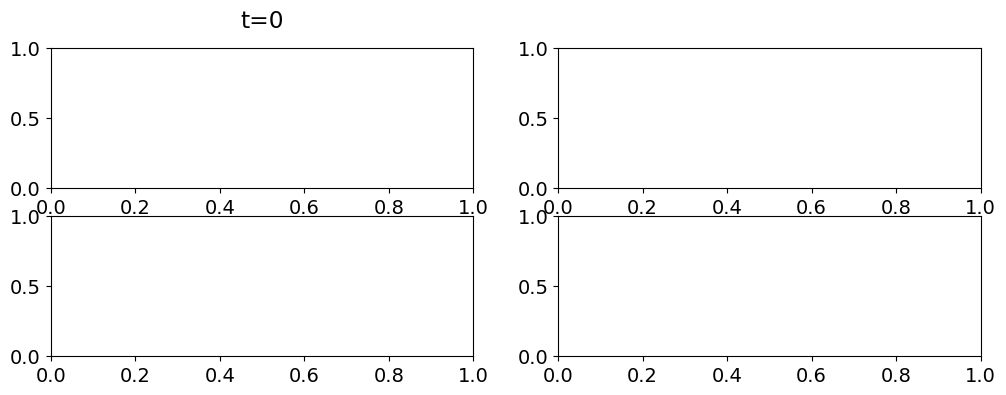

In [ ]:
points = [0,0]
import importlib
import graphing_pipeline
from random import choices
import matplotlib.pyplot as plt
importlib.reload(graphing_pipeline)
with torch.no_grad():
    idx = torch.tensor([list(choices(range(config.vocab_size), k=16))]).cuda()
    graphing_pipeline.attention_at([model], points, idx)
    # plt.savefig(f"final/{name}_attn.pdf", format='pdf')
    plt.show()

In [14]:
"""Heat maps of various measures of test performance"""

#derviative wrt log token, like anthropic paper, but doesn't look good
# derivative = torch.stack([(data[0][:,j] - data[0][:, j-1])*j for j in range(1,len(data[0][0]))])
print(data[0].shape)
sns.heatmap(((data[0][:,1:]-data[0][:,:-1]) * torch.arange(1,100)).T, cbar_kws={'label': 'd/d log(token) cross entropy loss compared with true distribution'}, center = 0, cmap ="vlag")
plt.xlabel(f"{train_config.max_iters/len(model_history)}  iterations")
# plt.axis()[0]
plt.ylabel(f"tokens")
plt.title(f"In-context learning of Markov Chain: log derivative of test loss\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()

sns.heatmap(data[0], cbar_kws={'label': 'cross entropy loss compared with true distribution'}, cmap ="rocket")
plt.xlabel("token")
plt.ylabel(f"{train_config.max_iters/len(model_history)} iterations")
plt.title(f"In-context learning of Markov Chain: in-context loss\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()

sns.heatmap(data[4], cbar_kws={'label': 'cross entropy loss compared with statistical average algorithm'}, center = 25)
plt.xlabel("token")
plt.ylabel(f"{train_config.max_iters/len(model_history)} iterations")
plt.title(f"In-context learning of Markov Chain: similarity to statistical algorithm\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()


sns.heatmap(data[5], cbar_kws={'label': 'cross entropy loss compared with unigram algorithm'}, center = 25)
plt.xlabel("token")
plt.ylabel(f"{train_config.max_iters/len(model_history)} iterations")
plt.title(f"In-context learning of Markov Chain: similarity to unigram algorithm\nlength={train_dataset.length}, num symbols={train_dataset.num_symbols}")
plt.show()

torch.Size([1])


NameError: name 'sns' is not defined

torch.Size([1, 100])


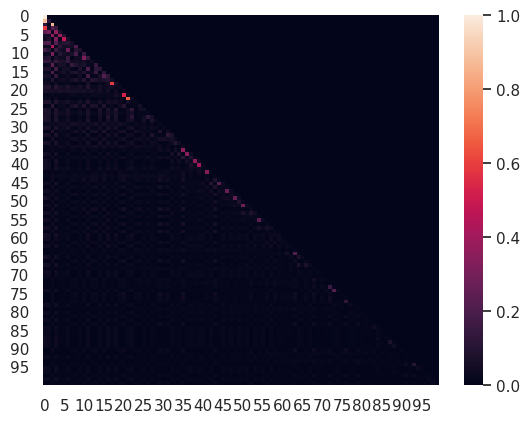

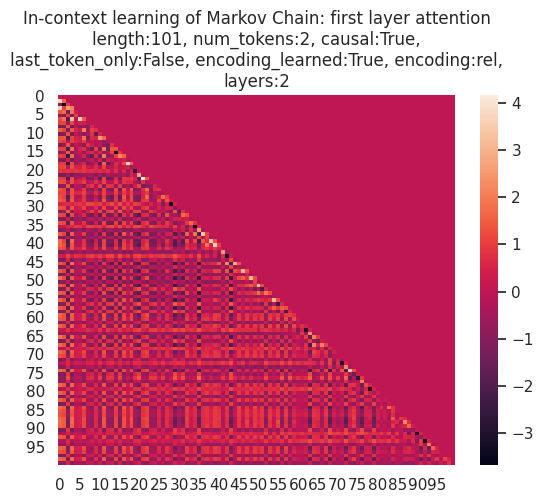

IndexError: too many indices for tensor of dimension 2

In [ ]:
with torch.no_grad():
    dataset = datasets.markov('test', length, num_tokens)
    x, y = dataset[0]
    # x, y = dataset[]
    idx = torch.stack([x]).to('cuda:0')
    print(idx.shape)
    attn = model.visualize_attention(idx)
    for layer in attn[:1]:
        sns.heatmap(F.softmax(layer[0,0], dim=-1).cpu())
        plt.show()
        temp = layer[0,0].masked_fill(model_history[100].transformer.h[0].attn.bias[0,0,:len(x),:len(x)] == 0, 0)
        sns.heatmap(temp.cpu())
        plt.title(f"In-context learning of Markov Chain: first layer attention\n"+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
        plt.show()
    prev = (idx[:,1]==idx.transpose(0,1)[:,:,0]).float()
    print(prev.shape)
    sns.heatmap(prev.cpu())
    plt.show()
    print(attn[0][0,0].cpu().flatten().max())
    temp = attn[0][0,0].masked_fill(model.transformer.h[0].attn.bias[0,0,:len(x),:len(x)] == 0, 2)
    norm = temp - temp.flatten().min()
    norm /= norm.flatten().max()
    sns.heatmap(norm.cpu(),center=0)
    plt.show()
    # diff = prev[:, :] - norm[:, :]
    # diff=diff.masked_fill(model.transformer.h[0].attn.bias[0,0,:len(x),:len(x)-1] == 0, float(diff.min()-1))
    # sns.heatmap(diff.cpu(), center = 0)
    # sns.heatmap((attn[0][0,0] + attn[1][0,0]).cpu())
    # plt.show()
    # sns.heatmap(torch.maximum((attn[2][0,0] + attn[3][0,0]).cpu(),torch.zeros_like(attn[0][0,0].cpu())))
    # plt.show()

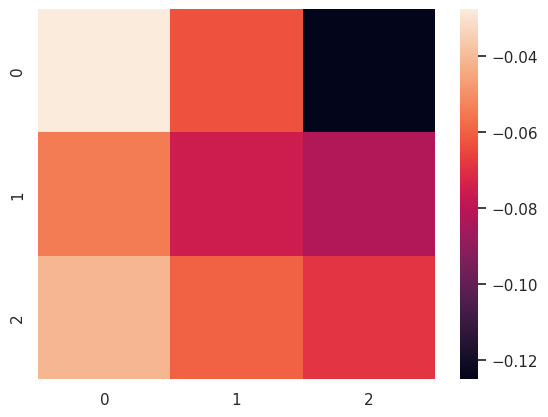

In [ ]:
with torch.no_grad():
    charts = [m.transformer.h[0].attn.Q.weight.cpu() for m in model_history]
    charts2 = [m.transformer.h[0].attn.K.weight.cpu() for m in model_history]
    import matplotlib.pyplot as plt
    fig = plt.figure()

    sns.set_theme(style="white")
    sns.heatmap(charts[100]@charts2[100].T)
@torch.no_grad
def animate(i):
    plt.clf()
    plt.title(f"In-context learning of Markov Chain: W\nt={i} "+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
    sns.heatmap(charts[i], cbar=None)
@torch.no_grad
def init():
    plt.clf()
    sns.heatmap(charts[0], cbar=None)
    plt.title(f"In-context learning of Markov Chain: W\nt=0 "+"\n".join(wrap(", ".join(f'{k}:{exprm_config[k]}' for k in exprm_config),60)))
# from matplotlib import animation
# with torch.no_grad():
#     anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(model_history), repeat = False, interval=0)
#     plt.show()
#     # sns.heatmap(charts[0][0], ax=ax1, cbar=None, square=True)
#     # sns.heatmap(charts[0][1], ax = ax2, cbar=None, square=True)
    # sns.heatmap(charts[0][2], ax=ax3, cbar=None, square=True)
    # plt.show()
# fig.show()


In [ ]:
"""Generating Attention maps"""
@torch.no_grad()
def test_forward(idx, test_model):
    device = idx.device
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
    tok_emb = test_model.transformer.wte(idx)
    pos_emb = test_model.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
    x = test_model.transformer.drop(tok_emb + pos_emb)
    out = []
    for block in test_model.transformer.h:
        #make sure block is fixed
        # if str(block) != "trained":
        #     continue
        
        residual_x = deepcopy(x)
        x = block.ln_1(x)
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = block.attn.c_attn(x).split(block.attn.n_embd, dim=2)
        k = k.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)

        # q = (x @ block.attn.Wq).view(B, 1, T, C) # (B, nh, T, hs)
        # k = (x @ block.attn.Wk).view(B, 1, T, C) # (B, nh, T, hs)
        # v = (x @ block.attn.Wv).view(B, 1, T, C) # (B, nh, T, hs)
        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # if self.abs_embd:
        #     att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # else:
        #     att = (q @ k.transpose(-2, -1) + torch.einsum("BhTe,Tte->BhTt", k, rel_encoding)) * (1.0 / math.sqrt(k.size(-1)))
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        #mask out top, but only for looks (pyplot doesn't play well with -inf)

        # temp = deepcopy(att)
        # temp = temp.masked_fill(block.attn.bias[:,:,:T,:T] == 0, 0)
        # for i in range(len(temp)):
        #     temp[i] = temp[i]/temp[i].sum() * (i + 1)
        # out.append(temp)
        att = att.masked_fill(block.attn.bias[:,:,:T,:T] == 0, float(att.min()-1))

        att = att.masked_fill(block.attn.bias[:,:,:T,:T] == 0, float('-inf'))
        out.append(deepcopy(att))
        att = F.softmax(att, dim=-1)
        temp = deepcopy(att)
        for i in range(T):
           temp[0,0,i] = temp[0,0,i] * (i + 1) 
        out.append(temp)
        # out.append(deepcopy(att))
        # att = block.attn.attn_dropout(att)

        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = block.attn.resid_dropout(block.attn.c_proj(y))
        x = residual_x + y

        # out.append(test_model.transformer.ln_f(deepcopy(x)))
    return out
# importlib.reload(matplotlib)
from matplotlib import animation
with torch.no_grad():
    dataset = datasets.markov('test', length, num_tokens)
    x, y = dataset[0]
    xid = torch.stack([x]).to('cuda:0')
    info = []
    model_attention = test_forward(xid, model_history[-1])
    attn = [i.cpu() for i in model_attention]
    for amap in attn:
        sns.heatmap(amap[0,0])
        plt.show()
    # sns.heatmap(attn[2][0,0])
    # plt.show()
        # for layer in attn:
        #     sns.heatmap(layer[0,0])
        #     plt.show()
    # times = range(0,len(model_history))
    # for test in times:

    #     attn = test_forward(xid, model_history[test])
    #     attn = [i.cpu() for i in attn]
    #     info.append(attn)
B, T = xid.shape
H = 1
# prev = (xid.view(B, H, T).roll(1,-1)==xid.view(B, T, H)).view(B, H, T, T).float()
prev = 1-(xid.view(B, H, T)==xid.view(B, T, H)).view(B, H, T, T).float()

# prev = (xid[:,None]==xid[:,:,None])[:,None].float()
# prev -= torch.eye(len(x), device = xid.device)[None, None, :,:]
# # prev += 1
# for i in range(len(x)):
#     prev[0,0,:,i] += (attn[0][0,0,i:,i]).mean()
#     # if (attn[0][0,0,i,i] < -2).any():
#     #     prev[0,0,:,i] -= 2
# prev = prev.masked_fill(model.transformer.h[0].attn.bias[:,:,:len(x),:len(x)] == 0, float('-inf'))
prev = prev.masked_fill(model.transformer.h[0].attn.bias[:,:,:len(x),:len(x)] == 0, float(prev.min()-1))
# prev = prev.masked_fill(prev == 0, -3)
# prev = F.softmax(prev, dim=-1).cpu()

# plt.plot(attn[0][0,0,token])
# plt.plot(prev[0,0,token].cpu())
# plt.show()
# plt.title("Fixed Second Layer")
# # prev[0,0] = F.normalize(prev[0,0], p=1)
sns.heatmap(prev[0,0].cpu(), center = 0)
plt.show()
# # print(prev)
    

AttributeError: 'CausalSelfAttention' object has no attribute 'c_attn'

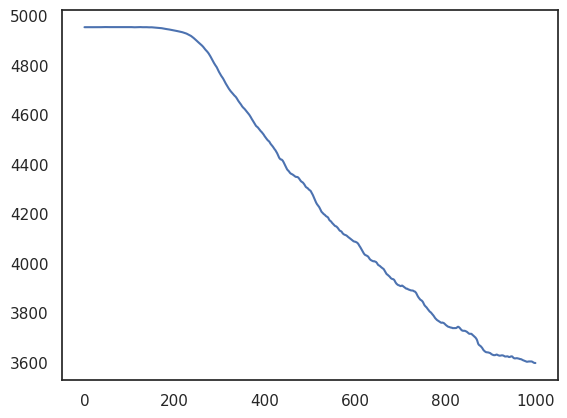

In [ ]:
T = length- 1
mask = torch.diag(torch.ones(T-1, device = info[0][0].device), -1)
# mask[0,0] = 1
# the_attention = torch.stack([torch.stack(elem) for elem in info])
# the_attention=torch.stack(info[0])
attention = []
for mod in info:
    # attention.append(mod[1].sum())
    attention.append(mod[1].masked_fill(mask == 1, 0).sum())
plt.plot(attention)

<video width="640" height="480" controls autoplay>
  <source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA5LFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRy

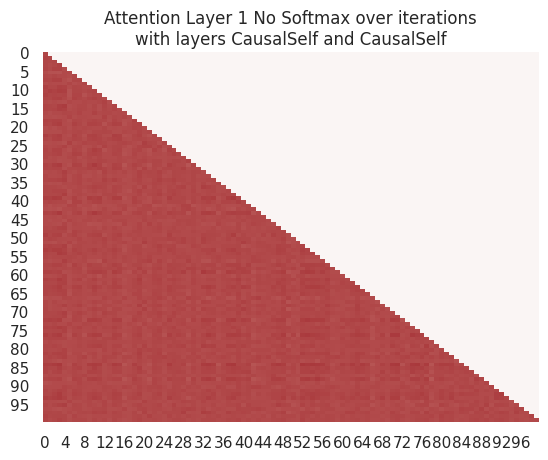

In [ ]:

fig, ax = plt.subplots()
names = [str(block.attn) for block in model.transformer.h]
names = [i[:i.find("Attention")] for i in names]
names = f"{names[0]} and {names[1]}"
def animate(i):
    sns.heatmap(torch.exp(info[i][0][0,0]), ax=ax, center =0, cmap= "vlag", cbar=False)
from IPython.display import HTML
def init():
    plt.title(f"Attention Layer 1 No Softmax over iterations\nwith layers {names}")
    sns.heatmap(torch.exp(info[0][0][0,0]), ax=ax, center=0, cmap= "vlag", cbar=False)
ani = animation.FuncAnimation(fig, init_func = init, func = animate, frames = range(0,len(info),20), interval = 50, repeat=False)

#I can't get these animations to work on jupyter, only workaround I have found is to convert them to HTML, then use that.
test = ani.to_html5_video()
test = HTML(ani.to_html5_video())
print(test.data)
to_save = test.data
with open("test.html", "w") as file:
    file.write(to_save)